In [41]:
import numpy as np
import pandas as pd
import SolveLinSys
import matplotlib.pyplot as plt
from numba import njit

import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
from scipy.interpolate import interp2d
from solver_2d import false_transient_one_iteration_python
from derivative import derivatives_2d

In [2]:
@njit
def compute_derivatives(data, dim, order, dlt):
    res = np.zeros_like(data)
    if order == 1:                    # first order derivatives
        if dim == 0:                  # to first dimension
            res[1:,:] = (1 / dlt) * (data[1:,:] - data[:-1,:])
            res[0,:] = (1 / dlt) * (data[1,:] - data[0,:])
        elif dim == 1:                # to second dimension
            res[:,1:] = (1 / dlt) * (data[:,1:] - data[:,:-1])
            res[:,0] = (1 / dlt) * (data[:,1] - data[:,0])        
    elif order == 2:
        if dim == 0:                  # to first dimension
            res[1:-1,:] = (1 / dlt ** 2) * (data[2:,:] + data[:-2,:] - 2 * data[1:-1,:])
            res[-1,:] = (1 / dlt ** 2) * (data[-1,:] + data[-3,:] - 2 * data[-2,:])
            res[0,:] = (1 / dlt ** 2) * (data[2,:] + data[0,:] - 2 * data[1,:])
        elif dim == 1:                # to second dimension
            res[:,1:-1] = (1 / dlt ** 2) * (data[:,2:] + data[:,:-2] - 2 * data[:,1:-1])
            res[:,-1] = (1 / dlt ** 2) * (data[:,-1] + data[:,-3] - 2 * data[:,-2])
            res[:,0] = (1 / dlt ** 2) * (data[:,2] + data[:,0] - 2 * data[:,1])    
    return res

def false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B1.reshape(-1, 1, order='F'), B2.reshape(-1, 1, order='F')])
    C = np.hstack([C1.reshape(-1, 1, order='F'), C2.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out

PDE:
\begin{align*}
0 = \max_{\mathcal{E}}  &  -\delta \phi(y_1, y_2) + \eta \log \mathcal{E} \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} (-\lambda y_2 + \lambda \sum_{i=1}^m \pi^p_i \theta_i \mathcal{E})\\
&+ \frac{\eta-1}{\delta}\left[\gamma_1 + \gamma_2 y_1 + \gamma_2^+\boldsymbol{1}_{y_1\geq \bar{y}_1}(y_1-\bar{y}_1)\right]y_2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)
\end{align*}

FOC of $\mathcal{E}$ gives:
$$
\mathcal{E} = -\frac{\eta}{\frac{\partial \phi}{\partial y_2} \lambda \sum_{i=1}^m \pi^d_i \theta_i}
$$

In [42]:
def false_transient(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, γ_2p, y_bar, πc_o, ξ_a = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)
    e_tilde = np.array(0)

    d_Λ = γ_1 + γ_2*y1_mat + γ_2p*(y1_mat>y_bar)*(y1_mat-y_bar)

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde.copy()

#         v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
#         v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        
        v0_dy1 = derivatives_2d(v0, 0, 1, dy1)
        v0_dy2 = derivatives_2d(v0, 1, 1, dy2)          
        
        e_tilde = -η/(v0_dy2*λ*np.sum(πc_o*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15
        e_tilde = e_tilde*.5 + e_tilde_old*.5

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        res = false_transient_one_iteration(stateSpace, A, B1, B2, C1, C2, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [43]:
ξ_a = 1./100
ξ_p = 5.

# λ = .116 # half life = 6 years
λ = np.log(2)/6 # half life = 6 years

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2, .3853*2])
πd_o = np.array([1./3, 1./3, 1./3])

y1_step = .04
y1_grid_long = np.arange(0., 4., y1_step)
y1_grid_short = np.arange(0., 2.+y1_step, y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

ϕ_i = []
ems_i = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, γ_1, γ_2, γ_2p_i, y_bar, πc_o, ξ_a)
    model_res = false_transient(y1_grid_long, y2_grid, model_paras,
                                v0=None, ϵ=.5, tol=1e-8, max_iter=3000, print_all=True)
    ϕ_i.append(model_res['v0'])
    ems_i.append(model_res['e_tilde'])

Iteration 1: LHS Error: 0.17063103370856317; RHS Error 0.23241194410363883
Iteration 2: LHS Error: 0.1531306266887033; RHS Error 0.17380951849505852
Iteration 3: LHS Error: 0.1849492612269706; RHS Error 0.2523263801525074
Iteration 4: LHS Error: 0.17825030876718662; RHS Error 0.3001325815293316
Iteration 5: LHS Error: 0.18004104964820072; RHS Error 0.2235153843886042
Iteration 6: LHS Error: 0.17557282933032572; RHS Error 0.25747893581142844
Iteration 7: LHS Error: 0.16112552816598547; RHS Error 0.2714479224824024
Iteration 8: LHS Error: 0.15022971578283434; RHS Error 0.1776929163099031
Iteration 9: LHS Error: 0.14266373578754; RHS Error 0.15664541523186884
Iteration 10: LHS Error: 0.137764414736798; RHS Error 0.1451805843053188
Iteration 11: LHS Error: 0.1344311272162202; RHS Error 0.13745297586851915
Iteration 12: LHS Error: 0.12895190278928337; RHS Error 0.1342301629081219
Iteration 13: LHS Error: 0.12299517288330541; RHS Error 0.12909658989544764
Iteration 14: LHS Error: 0.117515544

Iteration 109: LHS Error: 0.03556660301741843; RHS Error 0.0357031087766244
Iteration 110: LHS Error: 0.03530730602188292; RHS Error 0.03544324957551896
Iteration 111: LHS Error: 0.0350501435934083; RHS Error 0.035185457052376995
Iteration 112: LHS Error: 0.03479515773462616; RHS Error 0.03492978373633458
Iteration 113: LHS Error: 0.03454238058705439; RHS Error 0.034676271992279836
Iteration 114: LHS Error: 0.034291834583332736; RHS Error 0.034424954061468865
Iteration 115: LHS Error: 0.0340435329748372; RHS Error 0.03417585252662954
Iteration 116: LHS Error: 0.033797480505197264; RHS Error 0.03392898079388432
Iteration 117: LHS Error: 0.033553674193994354; RHS Error 0.033684343762538316
Iteration 118: LHS Error: 0.033312104189540115; RHS Error 0.033441938610814986
Iteration 119: LHS Error: 0.033072754770389956; RHS Error 0.03320175564976492
Iteration 120: LHS Error: 0.03283560485411563; RHS Error 0.03296377920651257
Iteration 121: LHS Error: 0.03260062928383878; RHS Error 0.0327279886

Iteration 214: LHS Error: 0.017451607459751273; RHS Error 0.017540116386223242
Iteration 215: LHS Error: 0.017341581198925482; RHS Error 0.017429888727903797
Iteration 216: LHS Error: 0.017232354713089038; RHS Error 0.017320463841754938
Iteration 217: LHS Error: 0.017123920522228886; RHS Error 0.01721183419826279
Iteration 218: LHS Error: 0.017016271238096792; RHS Error 0.01710399236233745
Iteration 219: LHS Error: 0.016909399561047422; RHS Error 0.016996930989843756
Iteration 220: LHS Error: 0.01680329827746796; RHS Error 0.016890642824887184
Iteration 221: LHS Error: 0.016697960257051392; RHS Error 0.01678512069689829
Iteration 222: LHS Error: 0.01659337845050146; RHS Error 0.016680357518197964
Iteration 223: LHS Error: 0.016489545887212742; RHS Error 0.01657634628145524
Iteration 224: LHS Error: 0.016386455673279343; RHS Error 0.016473080057618134
Iteration 225: LHS Error: 0.016284100989548023; RHS Error 0.016370551993791713
Iteration 226: LHS Error: 0.016182475089911108; RHS Error 

Iteration 319: LHS Error: 0.009193208060429114; RHS Error 0.009270661265082664
Iteration 320: LHS Error: 0.009138823952339337; RHS Error 0.00921621196237829
Iteration 321: LHS Error: 0.009084796895642455; RHS Error 0.009162119380800665
Iteration 322: LHS Error: 0.009031124002568447; RHS Error 0.009108380882983144
Iteration 323: LHS Error: 0.008977803909822057; RHS Error 0.009054995527320892
Iteration 324: LHS Error: 0.008924834618497357; RHS Error 0.00900196106499733
Iteration 325: LHS Error: 0.008872214125835498; RHS Error 0.008949275463291329
Iteration 326: LHS Error: 0.008819940434236173; RHS Error 0.00889693672418862
Iteration 327: LHS Error: 0.00876801155218665; RHS Error 0.008844942860082305
Iteration 328: LHS Error: 0.008716425493366486; RHS Error 0.008793291890045948
Iteration 329: LHS Error: 0.008665180275045259; RHS Error 0.00874198183846163
Iteration 330: LHS Error: 0.008614273916426995; RHS Error 0.00869101073326796
Iteration 331: LHS Error: 0.00856370443722021; RHS Error 0

Iteration 429: LHS Error: 0.004915483890469474; RHS Error 0.004988114173121089
Iteration 430: LHS Error: 0.004888492297164149; RHS Error 0.004961107725005812
Iteration 431: LHS Error: 0.004861655858952929; RHS Error 0.004934256737503959
Iteration 432: LHS Error: 0.004834973454752145; RHS Error 0.004907560080645523
Iteration 433: LHS Error: 0.00480844397863045; RHS Error 0.004881016639785296
Iteration 434: LHS Error: 0.0047820663396649365; RHS Error 0.004854625315426284
Iteration 435: LHS Error: 0.0047558394614810595; RHS Error 0.004828385022746795
Iteration 436: LHS Error: 0.004729762282190464; RHS Error 0.0048022946916182335
Iteration 437: LHS Error: 0.004703833754067688; RHS Error 0.004776353266201988
Iteration 438: LHS Error: 0.004678052843281932; RHS Error 0.004750559704728971
Iteration 439: LHS Error: 0.004652418529728308; RHS Error 0.004724912979273299
Iteration 440: LHS Error: 0.004626929806644142; RHS Error 0.004699412075452741
Iteration 441: LHS Error: 0.004601585680516607; RH

Iteration 539: LHS Error: 0.002694382248996874; RHS Error 0.0027661588193138437
Iteration 540: LHS Error: 0.0026797682490435903; RHS Error 0.0027515401453268723
Iteration 541: LHS Error: 0.0026652346112605585; RHS Error 0.0027370018642899896
Iteration 542: LHS Error: 0.002650780886568782; RHS Error 0.002722543526969337
Iteration 543: LHS Error: 0.002636406628408139; RHS Error 0.0027081646865834003
Iteration 544: LHS Error: 0.00262211139272317; RHS Error 0.0026938648989014713
Iteration 545: LHS Error: 0.002607894737998606; RHS Error 0.002679643722219918
Iteration 546: LHS Error: 0.0025937562252114077; RHS Error 0.002665500717340799
Iteration 547: LHS Error: 0.0025796954177597087; RHS Error 0.0026514354474945906
Iteration 548: LHS Error: 0.0025657118815125557; RHS Error 0.0026374474784047613
Iteration 549: LHS Error: 0.0025518051847654988; RHS Error 0.0026235363782007304
Iteration 550: LHS Error: 0.0025379748982121697; RHS Error 0.002609701717397536
Iteration 551: LHS Error: 0.0025242205

Iteration 649: LHS Error: 0.0014845811984649515; RHS Error 0.0015559984590163417
Iteration 650: LHS Error: 0.0014765842787483052; RHS Error 0.001547999358598534
Iteration 651: LHS Error: 0.0014686308357081401; RHS Error 0.0015400437469648837
Iteration 652: LHS Error: 0.0014607206317887034; RHS Error 0.001532131386449198
Iteration 653: LHS Error: 0.0014528534307505225; RHS Error 0.0015242620406673013
Iteration 654: LHS Error: 0.0014450289976934982; RHS Error 0.0015164354746444592
Iteration 655: LHS Error: 0.0014372470990480224; RHS Error 0.0015086514547038993
Iteration 656: LHS Error: 0.0014295075025607673; RHS Error 0.001500909748502588
Iteration 657: LHS Error: 0.0014218099772183024; RHS Error 0.001493210124949726
Iteration 658: LHS Error: 0.001414154293360781; RHS Error 0.001485552354325001
Iteration 659: LHS Error: 0.00140654033603127; RHS Error 0.0014779362096331294
Iteration 660: LHS Error: 0.0013989675669012769; RHS Error 0.0014703606906917577
Iteration 661: LHS Error: 0.00139143

Iteration 759: LHS Error: 0.000821083299609171; RHS Error 0.0008923186836893721
Iteration 760: LHS Error: 0.0008166902314510338; RHS Error 0.0008879244249414137
Iteration 761: LHS Error: 0.0008123209698336353; RHS Error 0.000883553980503618
Iteration 762: LHS Error: 0.0008079753837080261; RHS Error 0.0008792072193528622
Iteration 763: LHS Error: 0.0008036533427588921; RHS Error 0.0008748840110926887
Iteration 764: LHS Error: 0.0007993547173850146; RHS Error 0.0008705842260895019
Iteration 765: LHS Error: 0.0007950793787792065; RHS Error 0.0008663077354440635
Iteration 766: LHS Error: 0.0007908271988803506; RHS Error 0.0008620544109940592
Iteration 767: LHS Error: 0.0007865980503680703; RHS Error 0.0008578241253602015
Iteration 768: LHS Error: 0.0007823918067053626; RHS Error 0.0008536167518961024
Iteration 769: LHS Error: 0.0007782083421066233; RHS Error 0.0008494321647355696
Iteration 770: LHS Error: 0.000774047531526989; RHS Error 0.0008452702387285599
Iteration 771: LHS Error: 0.000

Iteration 869: LHS Error: 0.0004560866452720802; RHS Error 0.0005272278944016134
Iteration 870: LHS Error: 0.0004536642652510636; RHS Error 0.0005248049239737623
Iteration 871: LHS Error: 0.000451254905154741; RHS Error 0.0005223949772193981
Iteration 872: LHS Error: 0.0004488585588795502; RHS Error 0.0005199979847283764
Iteration 873: LHS Error: 0.00044647502194727906; RHS Error 0.0005176132036675274
Iteration 874: LHS Error: 0.00044410436024122646; RHS Error 0.0005152418286695354
Iteration 875: LHS Error: 0.00044174643817029846; RHS Error 0.0005128833376352171
Iteration 876: LHS Error: 0.00043940115741492036; RHS Error 0.0005105375308996213
Iteration 877: LHS Error: 0.000437068444961497; RHS Error 0.000508204298667797
Iteration 878: LHS Error: 0.00043474823966782594; RHS Error 0.0005058835667201417
Iteration 879: LHS Error: 0.0004324404836104634; RHS Error 0.0005035752748526884
Iteration 880: LHS Error: 0.0004301451179529181; RHS Error 0.0005012793664767312
Iteration 881: LHS Error: 

Iteration 981: LHS Error: 0.0002517181940984159; RHS Error 0.00032281244858173297
Iteration 982: LHS Error: 0.00025039048017028165; RHS Error 0.00032148444170251866
Iteration 983: LHS Error: 0.0002490698478858633; RHS Error 0.00032016351838534685
Iteration 984: LHS Error: 0.00024775625893802555; RHS Error 0.0003188496403441071
Iteration 985: LHS Error: 0.0002464496752434542; RHS Error 0.0003175427694450672
Iteration 986: LHS Error: 0.00024515005890179964; RHS Error 0.00031624286778114685
Iteration 987: LHS Error: 0.00024385737227383686; RHS Error 0.00031494989766148174
Iteration 988: LHS Error: 0.00024257157789264738; RHS Error 0.00031366382162717477
Iteration 989: LHS Error: 0.00024129263855598992; RHS Error 0.00031238460242893895
Iteration 990: LHS Error: 0.00024002051725169338; RHS Error 0.00031111220304355647
Iteration 991: LHS Error: 0.00023875517715232775; RHS Error 0.0003098465866293587
Iteration 992: LHS Error: 0.0002374965816915875; RHS Error 0.0003085877165942136
Iteration 99

Iteration 1081: LHS Error: 0.00014855757243381618; RHS Error 0.00021962934641432674
Iteration 1082: LHS Error: 0.00014777847163571778; RHS Error 0.00021885002647867302
Iteration 1083: LHS Error: 0.00014700349275642566; RHS Error 0.00021807489944249137
Iteration 1084: LHS Error: 0.00014623261269619547; RHS Error 0.00021730388065618889
Iteration 1085: LHS Error: 0.00014546580727881064; RHS Error 0.00021653693930932805
Iteration 1086: LHS Error: 0.00014470305443126108; RHS Error 0.0002157740511444517
Iteration 1087: LHS Error: 0.00014394433452302735; RHS Error 0.00021501519439058592
Iteration 1088: LHS Error: 0.00014318962958803638; RHS Error 0.000214260349534659
Iteration 1089: LHS Error: 0.0001424389222197675; RHS Error 0.0002135094987559677
Iteration 1090: LHS Error: 0.00014169219444504222; RHS Error 0.00021276262473619856
Iteration 1091: LHS Error: 0.00014094942722486792; RHS Error 0.00021201970968599826
Iteration 1092: LHS Error: 0.00014021060029634214; RHS Error 0.000211280734755542

Iteration 1184: LHS Error: 8.65608862739009e-05; RHS Error 0.00016068186353455916
Iteration 1185: LHS Error: 8.610938146702551e-05; RHS Error 0.00016112961073466714
Iteration 1186: LHS Error: 8.56602545589169e-05; RHS Error 0.00016157500372657174
Iteration 1187: LHS Error: 8.521349302625936e-05; RHS Error 0.00016201805504321987
Iteration 1188: LHS Error: 8.476908443988407e-05; RHS Error 0.0001624587771537761
Iteration 1189: LHS Error: 8.432701635463502e-05; RHS Error 0.00016289718240519724
Iteration 1190: LHS Error: 8.388727640706861e-05; RHS Error 0.00016333328314921403
Iteration 1191: LHS Error: 8.344985224262302e-05; RHS Error 0.00016376709159769687
Iteration 1192: LHS Error: 8.301473158489614e-05; RHS Error 0.00016419861993280382
Iteration 1193: LHS Error: 8.258190215748584e-05; RHS Error 0.0001646278802563822
Iteration 1194: LHS Error: 8.215135177280786e-05; RHS Error 0.00016505488461592
Iteration 1195: LHS Error: 8.172306825926512e-05; RHS Error 0.00016547964497341805
Iteration 1

Iteration 1291: LHS Error: 4.9538508653412805e-05; RHS Error 0.00019741161560295206
Iteration 1292: LHS Error: 4.928146709914927e-05; RHS Error 0.00019766675096810626
Iteration 1293: LHS Error: 4.90257712577602e-05; RHS Error 0.00019792055256398489
Iteration 1294: LHS Error: 4.877159431870837e-05; RHS Error 0.00019817302767957679
Iteration 1295: LHS Error: 4.85186521501646e-05; RHS Error 0.00019842414847050238
Iteration 1296: LHS Error: 4.826693246151592e-05; RHS Error 0.0001986739702413559
Iteration 1297: LHS Error: 4.801649135188768e-05; RHS Error 0.00019892250564688962
Iteration 1298: LHS Error: 4.77673587084837e-05; RHS Error 0.00019916975168170203
Iteration 1299: LHS Error: 4.7519543603158354e-05; RHS Error 0.0001994157073925834
Iteration 1300: LHS Error: 4.7273042373063845e-05; RHS Error 0.00019966037566970796
Iteration 1301: LHS Error: 4.7027845157643355e-05; RHS Error 0.00019990376212378203
Iteration 1302: LHS Error: 4.678394021873089e-05; RHS Error 0.00020014587374583837
Itera

Iteration 1398: LHS Error: 2.8430128429235424e-05; RHS Error 0.00021837129728037585
Iteration 1399: LHS Error: 2.8283319373656468e-05; RHS Error 0.0002185171457209506
Iteration 1400: LHS Error: 2.8137275105422077e-05; RHS Error 0.00021866223619330938
Iteration 1401: LHS Error: 2.7991991238707215e-05; RHS Error 0.00021880657268019688
Iteration 1402: LHS Error: 2.784746352979539e-05; RHS Error 0.0002189501591671611
Iteration 1403: LHS Error: 2.7703687706548408e-05; RHS Error 0.00021909299959363415
Iteration 1404: LHS Error: 2.7560659626502115e-05; RHS Error 0.00021923509789141538
Iteration 1405: LHS Error: 2.741837521647028e-05; RHS Error 0.00021937645796389627
Iteration 1406: LHS Error: 2.7276830458333734e-05; RHS Error 0.0002195170836793714
Iteration 1407: LHS Error: 2.7136021406803934e-05; RHS Error 0.0002196569789089109
Iteration 1408: LHS Error: 2.699594421784468e-05; RHS Error 0.00021979614746571452
Iteration 1409: LHS Error: 2.685659503320892e-05; RHS Error 0.0002199345931627461
I

Iteration 1505: LHS Error: 1.6356556356456053e-05; RHS Error 0.00023036949860089084
Iteration 1506: LHS Error: 1.627257283587369e-05; RHS Error 0.00023045330553250754
Iteration 1507: LHS Error: 1.618892732935251e-05; RHS Error 0.0002305365397945458
Iteration 1508: LHS Error: 1.610566513399192e-05; RHS Error 0.0002306192980191385
Iteration 1509: LHS Error: 1.6022819053773674e-05; RHS Error 0.00023070161191098004
Iteration 1510: LHS Error: 1.5940405850400907e-05; RHS Error 0.00023078349636555806
Iteration 1511: LHS Error: 1.58584313361132e-05; RHS Error 0.00023086495919795447
Iteration 1512: LHS Error: 1.5776894384700313e-05; RHS Error 0.0002309460045374495
Iteration 1513: LHS Error: 1.5695790011704958e-05; RHS Error 0.00023102663468510531
Iteration 1514: LHS Error: 1.5615111644606827e-05; RHS Error 0.00023110685112948115
Iteration 1515: LHS Error: 1.5534852746412753e-05; RHS Error 0.00023118665506907665
Iteration 1516: LHS Error: 1.5455007769560325e-05; RHS Error 0.00023126604771633863


Iteration 1613: LHS Error: 9.383306288412996e-06; RHS Error 0.00023730424980739073
Iteration 1614: LHS Error: 9.33523987356466e-06; RHS Error 0.00023735206294718536
Iteration 1615: LHS Error: 9.287421786297045e-06; RHS Error 0.0002373996296704678
Iteration 1616: LHS Error: 9.239851003428612e-06; RHS Error 0.00023744695121910575
Iteration 1617: LHS Error: 9.19252643427626e-06; RHS Error 0.00023749402880116066
Iteration 1618: LHS Error: 9.145446940195257e-06; RHS Error 0.000237540863626845
Iteration 1619: LHS Error: 9.098611315039307e-06; RHS Error 0.00023758745692864514
Iteration 1620: LHS Error: 9.052018292265984e-06; RHS Error 0.0002376338099356612
Iteration 1621: LHS Error: 9.005666571582083e-06; RHS Error 0.0002376799238590771
Iteration 1622: LHS Error: 8.959554817167259e-06; RHS Error 0.000237725799958996
Iteration 1623: LHS Error: 8.913681682543029e-06; RHS Error 0.00023777143944023194
Iteration 1624: LHS Error: 8.868045807020053e-06; RHS Error 0.00023781684354504118
Iteration 162

Iteration 1721: LHS Error: 5.3946365259349705e-06; RHS Error 0.00024127348481364774
Iteration 1722: LHS Error: 5.3671080060269105e-06; RHS Error 0.00024130089153624745
Iteration 1723: LHS Error: 5.339720727803865e-06; RHS Error 0.00024132815774702276
Iteration 1724: LHS Error: 5.31210193699394e-06; RHS Error 0.00024135528418421648
Iteration 1725: LHS Error: 5.285080526107322e-06; RHS Error 0.00024138231226743245
Iteration 1726: LHS Error: 5.258175479028182e-06; RHS Error 0.00024140917982609644
Iteration 1727: LHS Error: 5.23139467567546e-06; RHS Error 0.00024143590566198803
Iteration 1728: LHS Error: 5.204736185149272e-06; RHS Error 0.00024146248529927083
Iteration 1729: LHS Error: 5.1782063970051695e-06; RHS Error 0.0002414889222547567
Iteration 1730: LHS Error: 5.151799269853541e-06; RHS Error 0.00024151521700503664
Iteration 1731: LHS Error: 5.12552587927928e-06; RHS Error 0.0002415413766044816
Iteration 1732: LHS Error: 5.099380420148236e-06; RHS Error 0.00024156739912349623
Iterat

Iteration 1829: LHS Error: 3.106839088218294e-06; RHS Error 0.00024355187373144294
Iteration 1830: LHS Error: 3.091027958035397e-06; RHS Error 0.00024356762055315062
Iteration 1831: LHS Error: 3.0752963002811384e-06; RHS Error 0.00024358328697249299
Iteration 1832: LHS Error: 3.059643779224075e-06; RHS Error 0.00024359887346803166
Iteration 1833: LHS Error: 3.0440700999889714e-06; RHS Error 0.00024361438049003148
Iteration 1834: LHS Error: 3.028575026320368e-06; RHS Error 0.00024362980848964544
Iteration 1835: LHS Error: 3.0131583361736602e-06; RHS Error 0.00024364515788642682
Iteration 1836: LHS Error: 2.9978198003988155e-06; RHS Error 0.00024366042909529373
Iteration 1837: LHS Error: 2.982559218267511e-06; RHS Error 0.00024367562253428676
Iteration 1838: LHS Error: 2.967376373064212e-06; RHS Error 0.00024369073858424017
Iteration 1839: LHS Error: 2.9522710285334597e-06; RHS Error 0.00024370577765601975
Iteration 1840: LHS Error: 2.9372429146690138e-06; RHS Error 0.0002437207401343594

Iteration 1937: LHS Error: 1.7920434647322736e-06; RHS Error 0.0002448615767783463
Iteration 1938: LHS Error: 1.782967622432352e-06; RHS Error 0.00024487063731265524
Iteration 1939: LHS Error: 1.77390658429033e-06; RHS Error 0.0002448796458201091
Iteration 1940: LHS Error: 1.764923283076314e-06; RHS Error 0.000244888614411784
Iteration 1941: LHS Error: 1.7559546083845134e-06; RHS Error 0.0002448975314831986
Iteration 1942: LHS Error: 1.7470628748128547e-06; RHS Error 0.0002449064090169345
Iteration 1943: LHS Error: 1.738185565258732e-06; RHS Error 0.0002449152355474271
Iteration 1944: LHS Error: 1.7293843956878163e-06; RHS Error 0.00024492402292722315
Iteration 1945: LHS Error: 1.7205974938150348e-06; RHS Error 0.0002449327598052775
Iteration 1946: LHS Error: 1.7118859343412396e-06; RHS Error 0.00024494145793227395
Iteration 1947: LHS Error: 1.7031884755880355e-06; RHS Error 0.00024495010605340983
Iteration 1948: LHS Error: 1.6942346370285577e-06; RHS Error 0.00024495871640578537
Itera

Iteration 2045: LHS Error: 1.0355230770642265e-06; RHS Error 0.00024561569653618054
Iteration 2046: LHS Error: 1.0302890576241452e-06; RHS Error 0.00024562092784674583
Iteration 2047: LHS Error: 1.0250605537720503e-06; RHS Error 0.00024562612798509353
Iteration 2048: LHS Error: 1.0198761835056303e-06; RHS Error 0.00024563130609535355
Iteration 2049: LHS Error: 1.014697579293511e-06; RHS Error 0.00024563645349133523
Iteration 2050: LHS Error: 1.009563490583787e-06; RHS Error 0.0002456415791763089
Iteration 2051: LHS Error: 1.0044363616401597e-06; RHS Error 0.00024564667438897736
Iteration 2052: LHS Error: 9.993543468311827e-07; RHS Error 0.00024565174800751655
Iteration 2053: LHS Error: 9.942799472639763e-07; RHS Error 0.00024565679147728336
Iteration 2054: LHS Error: 9.892510242082153e-07; RHS Error 0.00024566181359174377
Iteration 2055: LHS Error: 9.842305619400804e-07; RHS Error 0.0002456668057449207
Iteration 2056: LHS Error: 9.792556383558804e-07; RHS Error 0.0002456717766345512
It

Iteration 2149: LHS Error: 6.110107175771873e-07; RHS Error 0.0002460389437479865
Iteration 2150: LHS Error: 6.079224554866869e-07; RHS Error 0.00024604202021591415
Iteration 2151: LHS Error: 6.048514418210971e-07; RHS Error 0.0002460450810325282
Iteration 2152: LHS Error: 6.017939995217603e-07; RHS Error 0.0002460481259847769
Iteration 2153: LHS Error: 5.987537452512015e-07; RHS Error 0.00024605115541523337
Iteration 2154: LHS Error: 5.957269504364149e-07; RHS Error 0.0002460541692252127
Iteration 2155: LHS Error: 5.92717247727137e-07; RHS Error 0.0002460571676563966
Iteration 2156: LHS Error: 5.89720906774005e-07; RHS Error 0.0002460601507047605
Iteration 2157: LHS Error: 5.867415442395441e-07; RHS Error 0.0002460631184973694
Iteration 2158: LHS Error: 5.838339376396107e-07; RHS Error 0.0002460660716437496
Iteration 2159: LHS Error: 5.809074465901176e-07; RHS Error 0.00024606890574424556
Iteration 2160: LHS Error: 5.778535570044596e-07; RHS Error 0.00024607187118946827
Iteration 2161

Iteration 2250: LHS Error: 3.66660145800779e-07; RHS Error 0.00024628221883024604
Iteration 2251: LHS Error: 3.6481602627702614e-07; RHS Error 0.0002462840551668011
Iteration 2252: LHS Error: 3.629751343936505e-07; RHS Error 0.00024628588033746845
Iteration 2253: LHS Error: 3.6115678092585313e-07; RHS Error 0.0002462876957696203
Iteration 2254: LHS Error: 3.5934176167984333e-07; RHS Error 0.00024628950093900925
Iteration 2255: LHS Error: 3.575481422046778e-07; RHS Error 0.0002462912969332792
Iteration 2256: LHS Error: 3.5575800794163115e-07; RHS Error 0.0002462930834597754
Iteration 2257: LHS Error: 3.539841539890176e-07; RHS Error 0.00024629486123114996
Iteration 2258: LHS Error: 3.5221404459662153e-07; RHS Error 0.0002462966301701869
Iteration 2259: LHS Error: 3.504569843215677e-07; RHS Error 0.0002462983906068861
Iteration 2260: LHS Error: 3.487015316494535e-07; RHS Error 0.0002463001427170236
Iteration 2261: LHS Error: 3.469598794936246e-07; RHS Error 0.0002463018864736488
Iteratio

Iteration 2357: LHS Error: 2.1390479076899283e-07; RHS Error 0.00024643485900718853
Iteration 2358: LHS Error: 2.128227105657743e-07; RHS Error 0.00024643593299145117
Iteration 2359: LHS Error: 2.1174093589593213e-07; RHS Error 0.0002464370154591361
Iteration 2360: LHS Error: 2.1066772148969903e-07; RHS Error 0.00024643808178706483
Iteration 2361: LHS Error: 2.096043516530699e-07; RHS Error 0.0002464391540546035
Iteration 2362: LHS Error: 2.0854539073411615e-07; RHS Error 0.0002464402111552605
Iteration 2363: LHS Error: 2.0749431683952935e-07; RHS Error 0.00024644127232353874
Iteration 2364: LHS Error: 2.0644764830990425e-07; RHS Error 0.0002464423189522391
Iteration 2365: LHS Error: 2.0540816159098085e-07; RHS Error 0.0002464433683882633
Iteration 2366: LHS Error: 2.043738209778212e-07; RHS Error 0.0002464444037530711
Iteration 2367: LHS Error: 2.0334454831072435e-07; RHS Error 0.00024644544114711675
Iteration 2368: LHS Error: 2.0232124242625105e-07; RHS Error 0.00024644646489271893
I

Iteration 2456: LHS Error: 1.2993657350079957e-07; RHS Error 0.0002465193443559194
Iteration 2457: LHS Error: 1.2928555470637093e-07; RHS Error 0.00024652001752609176
Iteration 2458: LHS Error: 1.2863904252924385e-07; RHS Error 0.00024652066656696836
Iteration 2459: LHS Error: 1.279954080501966e-07; RHS Error 0.00024652132925635784
Iteration 2460: LHS Error: 1.2735958065945852e-07; RHS Error 0.0002465219731513091
Iteration 2461: LHS Error: 1.2672441584982153e-07; RHS Error 0.00024652262562263605
Iteration 2462: LHS Error: 1.2609597810353534e-07; RHS Error 0.0002465232634243225
Iteration 2463: LHS Error: 1.2546827754533751e-07; RHS Error 0.00024652390607034225
Iteration 2464: LHS Error: 1.2484289335645826e-07; RHS Error 0.0002465245371459507
Iteration 2465: LHS Error: 1.2422142070533937e-07; RHS Error 0.00024652517044433664
Iteration 2466: LHS Error: 1.235990385595187e-07; RHS Error 0.00024652579439207734
Iteration 2467: LHS Error: 1.2298257168197324e-07; RHS Error 0.0002465264187988536

Iteration 2559: LHS Error: 8.396821638001484e-08; RHS Error 0.0002465714982999023
Iteration 2560: LHS Error: 8.394665762523346e-08; RHS Error 0.00024657191542458434
Iteration 2561: LHS Error: 8.358600656066528e-08; RHS Error 0.0002465722333232778
Iteration 2562: LHS Error: 8.358885494885726e-08; RHS Error 0.0002465726446030658
Iteration 2563: LHS Error: 8.331462630906117e-08; RHS Error 0.0002465729626345975
Iteration 2564: LHS Error: 8.327648259864873e-08; RHS Error 0.0002465733681395743
Iteration 2565: LHS Error: 8.306036747285361e-08; RHS Error 0.00024657368702477034
Iteration 2566: LHS Error: 8.297159226344775e-08; RHS Error 0.00024657408711033224
Iteration 2567: LHS Error: 8.272615392712623e-08; RHS Error 0.00024657440725067703
Iteration 2568: LHS Error: 8.262445572171373e-08; RHS Error 0.0002465748022747877
Iteration 2569: LHS Error: 8.227183023734597e-08; RHS Error 0.0002465751237676894
Iteration 2570: LHS Error: 8.215658198196252e-08; RHS Error 0.0002465755140506065
Iteration 25

Iteration 2667: LHS Error: 4.668376440974953e-08; RHS Error 0.00024660353161193305
Iteration 2668: LHS Error: 4.644204221193604e-08; RHS Error 0.00024660373484115816
Iteration 2669: LHS Error: 4.621149685135606e-08; RHS Error 0.00024660396933288975
Iteration 2670: LHS Error: 4.5975161455658053e-08; RHS Error 0.0002466041750643355
Iteration 2671: LHS Error: 4.574315148886399e-08; RHS Error 0.0002466044057712474
Iteration 2672: LHS Error: 4.550767318534099e-08; RHS Error 0.0002466046147203693
Iteration 2673: LHS Error: 4.5271776549782317e-08; RHS Error 0.00024660484156516227
Iteration 2674: LHS Error: 4.503488248985832e-08; RHS Error 0.00024660505415209644
Iteration 2675: LHS Error: 4.479615434149764e-08; RHS Error 0.0002466052769095478
Iteration 2676: LHS Error: 4.457030833293629e-08; RHS Error 0.00024660549335303594
Iteration 2677: LHS Error: 4.434818734466717e-08; RHS Error 0.00024660571173723556
Iteration 2678: LHS Error: 4.4122855591410826e-08; RHS Error 0.0002466059320532371
Iterat

Iteration 2777: LHS Error: 3.121947766970834e-08; RHS Error 0.00024662306675996004
Iteration 2778: LHS Error: 3.12535286539628e-08; RHS Error 0.00024662319217609585
Iteration 2779: LHS Error: 3.1265132705016185e-08; RHS Error 0.00024662331667486825
Iteration 2780: LHS Error: 3.1316727877594985e-08; RHS Error 0.0002466234402734857
Iteration 2781: LHS Error: 3.132995285426432e-08; RHS Error 0.0002466235630870367
Iteration 2782: LHS Error: 3.1395157584768185e-08; RHS Error 0.00024662368493114095
Iteration 2783: LHS Error: 3.142379068066248e-08; RHS Error 0.00024662380616316537
Iteration 2784: LHS Error: 3.151005323331901e-08; RHS Error 0.0002466239263363701
Iteration 2785: LHS Error: 3.1546180778718735e-08; RHS Error 0.00024662404620898193
Iteration 2786: LHS Error: 3.1650265519544973e-08; RHS Error 0.00024662416491999517
Iteration 2787: LHS Error: 3.1693653035347324e-08; RHS Error 0.00024662428385566204
Iteration 2788: LHS Error: 3.180757790488542e-08; RHS Error 0.0002466244015290747
Ite

Iteration 2877: LHS Error: 2.2295764345869884e-08; RHS Error 0.0002466323991855285
Iteration 2878: LHS Error: 2.2126024568080993e-08; RHS Error 0.00024663247934682275
Iteration 2879: LHS Error: 2.1949848161284535e-08; RHS Error 0.00024663254780454835
Iteration 2880: LHS Error: 2.1792578408508234e-08; RHS Error 0.00024663262710582223
Iteration 2881: LHS Error: 2.1631479718564606e-08; RHS Error 0.00024663269725275216
Iteration 2882: LHS Error: 2.1485700330003965e-08; RHS Error 0.0002466327754363645
Iteration 2883: LHS Error: 2.1338356859246232e-08; RHS Error 0.00024663284740286673
Iteration 2884: LHS Error: 2.1202840372325227e-08; RHS Error 0.0002466329242571952
Iteration 2885: LHS Error: 2.106777152732775e-08; RHS Error 0.0002466329981466453
Iteration 2886: LHS Error: 2.0941136824603745e-08; RHS Error 0.00024663307348707364
Iteration 2887: LHS Error: 2.0816809609414122e-08; RHS Error 0.0002466331493569396
Iteration 2888: LHS Error: 2.0697614289133526e-08; RHS Error 0.0002466332230323803

Iteration 2980: LHS Error: 1.2482763267485097e-08; RHS Error 0.0002466391109757077
Iteration 2981: LHS Error: 1.2417888939353361e-08; RHS Error 0.00024663917650304124
Iteration 2982: LHS Error: 1.2352291633987988e-08; RHS Error 0.00024663923675592725
Iteration 2983: LHS Error: 1.2289925521713485e-08; RHS Error 0.00024663930138818513
Iteration 2984: LHS Error: 1.222439394155117e-08; RHS Error 0.00024663935785418367
Iteration 2985: LHS Error: 1.2163541285303836e-08; RHS Error 0.00024663942140401574
Iteration 2986: LHS Error: 1.2099796720121958e-08; RHS Error 0.0002466394743891043
Iteration 2987: LHS Error: 1.2039359731375043e-08; RHS Error 0.0002466395367273777
Iteration 2988: LHS Error: 1.1978078973129413e-08; RHS Error 0.00024663958657288043
Iteration 2989: LHS Error: 1.1919944142846362e-08; RHS Error 0.00024663964758299406
Iteration 2990: LHS Error: 1.1859091486599027e-08; RHS Error 0.0002466396946745608
Iteration 2991: LHS Error: 1.1800874943901363e-08; RHS Error 0.000246639754274843

Iteration 95: LHS Error: 0.8685329688328665; RHS Error 5.513277068875789
Iteration 96: LHS Error: 0.864211909969967; RHS Error 3.412386964929953
Iteration 97: LHS Error: 0.8599123481573443; RHS Error 2.849866975522249
Iteration 98: LHS Error: 0.8556341780591907; RHS Error 2.8716142777419487
Iteration 99: LHS Error: 0.8513772912672195; RHS Error 2.893192490900187
Iteration 100: LHS Error: 0.8471415836479821; RHS Error 2.914607032446088
Iteration 101: LHS Error: 0.8429269493889038; RHS Error 2.935862935366941
Iteration 102: LHS Error: 0.8387332817256876; RHS Error 33.18051917022889
Iteration 103: LHS Error: 0.8345604797923301; RHS Error 13.919202916560453
Iteration 104: LHS Error: 0.8304084376474776; RHS Error 6.6080860637240555
Iteration 105: LHS Error: 0.8262770526348646; RHS Error 3.0193884140835943
Iteration 106: LHS Error: 0.8221662210827816; RHS Error 3.039914526120336
Iteration 107: LHS Error: 0.8180758421989012; RHS Error 3.0603052624654703
Iteration 108: LHS Error: 0.81400581323

Iteration 215: LHS Error: 0.4837746134955552; RHS Error 4.810567569389311
Iteration 216: LHS Error: 0.4749991552932755; RHS Error 6.78133114056763
Iteration 217: LHS Error: 0.47263597490440645; RHS Error 4.834721441664807
Iteration 218: LHS Error: 0.4702845516466283; RHS Error 4.846703650091336
Iteration 219: LHS Error: 0.4679448276345539; RHS Error 4.858623161073637
Iteration 220: LHS Error: 0.6364215493826464; RHS Error 4.870480313054398
Iteration 221: LHS Error: 0.5857540108643278; RHS Error 4.882275442750472
Iteration 222: LHS Error: 0.6035522443809569; RHS Error 4.894008884254849
Iteration 223: LHS Error: 0.565269437648567; RHS Error 4.905680969912247
Iteration 224: LHS Error: 0.6870474948604155; RHS Error 4.917292030381645
Iteration 225: LHS Error: 0.5149054232422827; RHS Error 4.928842394502178
Iteration 226: LHS Error: 0.45188946759799364; RHS Error 4.940332388931851
Iteration 227: LHS Error: 0.4496412613357279; RHS Error 4.95176233812155
Iteration 228: LHS Error: 0.44740424030

Iteration 330: LHS Error: 0.26900589337304837; RHS Error 5.860140513513075
Iteration 331: LHS Error: 0.26766755566771394; RHS Error 5.866790894074185
Iteration 332: LHS Error: 0.985364911218042; RHS Error 5.873406892301704
Iteration 333: LHS Error: 0.38288181062340243; RHS Error 5.879988688176474
Iteration 334: LHS Error: 0.26369236105264804; RHS Error 5.8865364605006105
Iteration 335: LHS Error: 0.2677403933014091; RHS Error 5.893050387707912
Iteration 336: LHS Error: 0.5495972280794916; RHS Error 5.899530646716716
Iteration 337: LHS Error: 0.7189899360988079; RHS Error 5.905977413600381
Iteration 338: LHS Error: 0.4199772962797397; RHS Error 5.91239086326012
Iteration 339: LHS Error: 0.3377713993153719; RHS Error 5.9187711705484
Iteration 340: LHS Error: 0.2970956983985502; RHS Error 5.925118508327212
Iteration 341: LHS Error: 1.890932566227498; RHS Error 5.931433049091137
Iteration 342: LHS Error: 1.1153445663452004; RHS Error 5.937714964259395
Iteration 343: LHS Error: 0.7048919167

Iteration 450: LHS Error: 0.21284779363026018; RHS Error 27.949660620585785
Iteration 451: LHS Error: 0.2690288236044225; RHS Error 16.59639557888184
Iteration 452: LHS Error: 0.7018719916592815; RHS Error 9.119284052574372
Iteration 453: LHS Error: 0.3186269456277415; RHS Error 6.466896499971871
Iteration 454: LHS Error: 0.9298657063926399; RHS Error 6.470418606572622
Iteration 455: LHS Error: 1.1805502965674108; RHS Error 15.541160451882101
Iteration 456: LHS Error: 0.7149474575615073; RHS Error 16.17778008202592
Iteration 457: LHS Error: 0.6158891848308343; RHS Error 8.333641022019153
Iteration 458: LHS Error: 0.42389706705554175; RHS Error 6.484326859009431
Iteration 459: LHS Error: 1.6407827498592908; RHS Error 6.487759343257939
Iteration 460: LHS Error: 0.8735534365801598; RHS Error 6.491174180103918
Iteration 461: LHS Error: 0.48567393183834895; RHS Error 6.494571460628422
Iteration 462: LHS Error: 0.29965881217209756; RHS Error 6.497951275464143
Iteration 463: LHS Error: 0.3655

Iteration 566: LHS Error: 0.3266509817988208; RHS Error 6.769396272530244
Iteration 567: LHS Error: 0.23514049562035666; RHS Error 6.771364814821997
Iteration 568: LHS Error: 0.18934422409930107; RHS Error 6.773323259580267
Iteration 569: LHS Error: 0.8299247450501639; RHS Error 6.77527165868353
Iteration 570: LHS Error: 0.5464027247026593; RHS Error 7.308862225603635
Iteration 571: LHS Error: 0.20125539143176496; RHS Error 6.7791385271623765
Iteration 572: LHS Error: 0.38298403246720625; RHS Error 6.781057099471013
Iteration 573: LHS Error: 0.2993537496176799; RHS Error 6.782965831387863
Iteration 574: LHS Error: 0.4336572075103504; RHS Error 6.78486477382468
Iteration 575: LHS Error: 0.5709998954366142; RHS Error 6.786753977022457
Iteration 576: LHS Error: 0.3352755170059112; RHS Error 6.788633490315017
Iteration 577: LHS Error: 0.27497667407541826; RHS Error 6.79050336503815
Iteration 578: LHS Error: 0.23560202014567722; RHS Error 6.792363649263271
Iteration 579: LHS Error: 0.156661

Iteration 681: LHS Error: 1.33943163129193; RHS Error 15.133442640863752
Iteration 682: LHS Error: 0.8465600919827381; RHS Error 6.941846074699452
Iteration 683: LHS Error: 0.5266780652958545; RHS Error 6.94293069137533
Iteration 684: LHS Error: 0.7723437500959989; RHS Error 6.944009752414099
Iteration 685: LHS Error: 0.7608976046778508; RHS Error 6.945083287037971
Iteration 686: LHS Error: 1.5820489224392844; RHS Error 6.946151323372768
Iteration 687: LHS Error: 0.791990702604366; RHS Error 6.947213889173357
Iteration 688: LHS Error: 0.6112134939409373; RHS Error 6.948271012972992
Iteration 689: LHS Error: 1.5357813841188772; RHS Error 6.949322722371937
Iteration 690: LHS Error: 0.6194643005411251; RHS Error 6.9503690458950445
Iteration 691: LHS Error: 0.5852042338656247; RHS Error 6.9514100107749135
Iteration 692: LHS Error: 0.7331577880228224; RHS Error 6.952445644271177
Iteration 693: LHS Error: 0.3628442742545843; RHS Error 6.953475973079503
Iteration 694: LHS Error: 0.31529892231

Iteration 798: LHS Error: 0.6396436488367101; RHS Error 7.03689355742147
Iteration 799: LHS Error: 0.5399396174684199; RHS Error 7.037491568233088
Iteration 800: LHS Error: 0.23468087176736674; RHS Error 7.038086518698668
Iteration 801: LHS Error: 0.1919003615059438; RHS Error 7.038678425158109
Iteration 802: LHS Error: 0.18923719563868246; RHS Error 7.039267302707708
Iteration 803: LHS Error: 0.16100108877235186; RHS Error 7.039853167498733
Iteration 804: LHS Error: 0.1296395599261757; RHS Error 7.040436034153537
Iteration 805: LHS Error: 0.7998551213457006; RHS Error 7.04101591795785
Iteration 806: LHS Error: 0.3714170006487052; RHS Error 7.041592834592303
Iteration 807: LHS Error: 0.35560862514512337; RHS Error 7.0421667990542725
Iteration 808: LHS Error: 0.21280985337262592; RHS Error 7.042737827096394
Iteration 809: LHS Error: 0.3991341646834812; RHS Error 7.043305933140607
Iteration 810: LHS Error: 0.11607947545092401; RHS Error 7.043871131542581
Iteration 811: LHS Error: 0.49836

Iteration 917: LHS Error: 0.11957409945073039; RHS Error 7.090294368233936
Iteration 918: LHS Error: 0.13696716001923903; RHS Error 7.0906191961910885
Iteration 919: LHS Error: 1.0857409826938351; RHS Error 7.090942363149741
Iteration 920: LHS Error: 0.48245905399585354; RHS Error 7.0912638774341445
Iteration 921: LHS Error: 0.3419985542803232; RHS Error 7.091583748188465
Iteration 922: LHS Error: 0.6249388877403419; RHS Error 7.091901982568764
Iteration 923: LHS Error: 0.2976276596156282; RHS Error 7.092218588588264
Iteration 924: LHS Error: 0.5974510047490469; RHS Error 7.092533575761738
Iteration 925: LHS Error: 0.2597022561843261; RHS Error 7.0928469524635664
Iteration 926: LHS Error: 0.3817166090659896; RHS Error 7.093158726945162
Iteration 927: LHS Error: 0.1747259901311935; RHS Error 7.09346890700012
Iteration 928: LHS Error: 0.13846909719174505; RHS Error 7.093777500548346
Iteration 929: LHS Error: 0.27761346344185256; RHS Error 7.094084515930622
Iteration 930: LHS Error: 0.146

Iteration 1028: LHS Error: 0.7141637856008458; RHS Error 7.117859884660199
Iteration 1029: LHS Error: 0.2742237084128334; RHS Error 7.11804376597463
Iteration 1030: LHS Error: 0.5364520704439855; RHS Error 7.118226707585243
Iteration 1031: LHS Error: 0.20476708505964325; RHS Error 7.118408713316751
Iteration 1032: LHS Error: 0.11801794246720476; RHS Error 7.118589788449309
Iteration 1033: LHS Error: 0.7772120948208681; RHS Error 7.1187699381866905
Iteration 1034: LHS Error: 0.35445632362406343; RHS Error 7.118949166539128
Iteration 1035: LHS Error: 0.6922359874319284; RHS Error 7.119127479162165
Iteration 1036: LHS Error: 0.23087468883062456; RHS Error 7.119304880613476
Iteration 1037: LHS Error: 0.26960630323868884; RHS Error 7.119481374698871
Iteration 1038: LHS Error: 0.14390288080689118; RHS Error 7.1196569663831
Iteration 1039: LHS Error: 0.70039021865432; RHS Error 7.119831660584165
Iteration 1040: LHS Error: 0.2629386761628183; RHS Error 7.120005461700593
Iteration 1041: LHS Err

Iteration 1137: LHS Error: 0.1793636154984597; RHS Error 7.133255949655122
Iteration 1138: LHS Error: 0.1371295983791896; RHS Error 7.13336113555857
Iteration 1139: LHS Error: 0.10776418606923244; RHS Error 7.1334657835296955
Iteration 1140: LHS Error: 0.09585613146849425; RHS Error 7.133569896018132
Iteration 1141: LHS Error: 0.9975789230054062; RHS Error 7.133673476785709
Iteration 1142: LHS Error: 0.35353252454702044; RHS Error 7.133776528093045
Iteration 1143: LHS Error: 0.49788068792035745; RHS Error 7.13387905311725
Iteration 1144: LHS Error: 0.30632919988090634; RHS Error 7.133981053801239
Iteration 1145: LHS Error: 0.5225691261675252; RHS Error 7.134082533425559
Iteration 1146: LHS Error: 0.3935430500071533; RHS Error 7.134183494409044
Iteration 1147: LHS Error: 0.26188582883294487; RHS Error 7.134283939612479
Iteration 1148: LHS Error: 0.21178689191496858; RHS Error 7.1343838712634176
Iteration 1149: LHS Error: 0.14445140503624998; RHS Error 7.13448329219564
Iteration 1150: LH

Iteration 1250: LHS Error: 0.26117589331380486; RHS Error 7.142302428743269
Iteration 1251: LHS Error: 0.12328882668769836; RHS Error 7.142361386203886
Iteration 1252: LHS Error: 0.10313987038691153; RHS Error 7.142420042556343
Iteration 1253: LHS Error: 0.08627462880993164; RHS Error 7.1424783992363245
Iteration 1254: LHS Error: 0.21260176140052067; RHS Error 7.142536457910159
Iteration 1255: LHS Error: 0.0763412701855799; RHS Error 7.142594220179335
Iteration 1256: LHS Error: 0.786686563871001; RHS Error 7.1426516874830766
Iteration 1257: LHS Error: 0.23897952863941896; RHS Error 7.142708860416585
Iteration 1258: LHS Error: 0.3253923216469161; RHS Error 7.142765741489867
Iteration 1259: LHS Error: 0.19432483759841546; RHS Error 7.142822331804758
Iteration 1260: LHS Error: 0.4198153485545504; RHS Error 7.142878633245822
Iteration 1261: LHS Error: 0.8343913650863612; RHS Error 7.142934646849097
Iteration 1262: LHS Error: 0.2892643558383128; RHS Error 7.14299037424704
Iteration 1263: LH

Iteration 1363: LHS Error: 0.06304007233738673; RHS Error 7.1473734231796
Iteration 1364: LHS Error: 0.17866121769057486; RHS Error 7.147406474112923
Iteration 1365: LHS Error: 0.07980364126881057; RHS Error 7.1474393564655445
Iteration 1366: LHS Error: 0.30603128525432055; RHS Error 7.147472071069598
Iteration 1367: LHS Error: 0.24717630794043544; RHS Error 7.1475046182171535
Iteration 1368: LHS Error: 0.7205141760327791; RHS Error 7.147536999768466
Iteration 1369: LHS Error: 0.29046257975504375; RHS Error 7.147569215316961
Iteration 1370: LHS Error: 0.19651060736212855; RHS Error 7.147601266351099
Iteration 1371: LHS Error: 0.16050011142824872; RHS Error 7.1476331538991325
Iteration 1372: LHS Error: 0.3472382878777438; RHS Error 7.147664878266649
Iteration 1373: LHS Error: 0.39406174669689165; RHS Error 7.147696440476671
Iteration 1374: LHS Error: 0.1857328381042933; RHS Error 7.147727841673734
Iteration 1375: LHS Error: 0.15512470530461542; RHS Error 7.147759082210731
Iteration 1376

Iteration 1473: LHS Error: 0.3428908832919859; RHS Error 7.150160194302314
Iteration 1474: LHS Error: 0.1726582976826876; RHS Error 7.150179012402466
Iteration 1475: LHS Error: 0.2905640638975484; RHS Error 7.150197733753033
Iteration 1476: LHS Error: 0.08563838191955142; RHS Error 7.1502163599787405
Iteration 1477: LHS Error: 0.1386696584148055; RHS Error 7.150234890914262
Iteration 1478: LHS Error: 0.3036468039845772; RHS Error 7.15025332697731
Iteration 1479: LHS Error: 0.164305065821722; RHS Error 7.150271669217638
Iteration 1480: LHS Error: 0.5438674343523502; RHS Error 7.15028991771372
Iteration 1481: LHS Error: 0.648305409317274; RHS Error 7.150308073487727
Iteration 1482: LHS Error: 0.2371929507932009; RHS Error 7.150326135838401
Iteration 1483: LHS Error: 0.4575600872621237; RHS Error 7.150344105943378
Iteration 1484: LHS Error: 0.2626195544646919; RHS Error 7.150361984349872
Iteration 1485: LHS Error: 0.23025416539562116; RHS Error 7.150379771450972
Iteration 1486: LHS Error:

Iteration 1583: LHS Error: 0.15937671655211716; RHS Error 7.151746929648785
Iteration 1584: LHS Error: 0.10270496454693756; RHS Error 7.151757644849765
Iteration 1585: LHS Error: 0.08815034212472739; RHS Error 7.151768305392883
Iteration 1586: LHS Error: 0.09883625112512107; RHS Error 7.151778911399188
Iteration 1587: LHS Error: 0.08165397149168996; RHS Error 7.151789463994001
Iteration 1588: LHS Error: 0.06694398340276564; RHS Error 7.151799962318155
Iteration 1589: LHS Error: 0.22626912815290723; RHS Error 7.151810406758635
Iteration 1590: LHS Error: 0.18447705477070997; RHS Error 7.151820797168981
Iteration 1591: LHS Error: 0.4959419485468288; RHS Error 7.151831135235582
Iteration 1592: LHS Error: 0.45081807567977705; RHS Error 7.151841419901215
Iteration 1593: LHS Error: 0.4408944161743662; RHS Error 7.151851652126695
Iteration 1594: LHS Error: 0.21400598926456382; RHS Error 7.151861831816224
Iteration 1595: LHS Error: 2.0055985243905496; RHS Error 7.151871959983124
Iteration 1596:

Iteration 1693: LHS Error: 0.4619854032742694; RHS Error 7.152650496483234
Iteration 1694: LHS Error: 0.18729130684189954; RHS Error 7.152656598581459
Iteration 1695: LHS Error: 0.5674849314158479; RHS Error 7.152662669394996
Iteration 1696: LHS Error: 0.2991627254321898; RHS Error 7.15266870949827
Iteration 1697: LHS Error: 0.7474002203649377; RHS Error 7.152674717914271
Iteration 1698: LHS Error: 0.29652167048382694; RHS Error 7.152680696262404
Iteration 1699: LHS Error: 0.25506394282551526; RHS Error 7.152686644452607
Iteration 1700: LHS Error: 0.20451788217560818; RHS Error 7.152692562012385
Iteration 1701: LHS Error: 0.30001038709042405; RHS Error 7.152698449188376
Iteration 1702: LHS Error: 0.16962363299134608; RHS Error 7.152704306043967
Iteration 1703: LHS Error: 0.8939531854674811; RHS Error 7.15271013349309
Iteration 1704: LHS Error: 0.5268808224051753; RHS Error 7.152715931131016
Iteration 1705: LHS Error: 0.18920927621961425; RHS Error 7.1527216993273095
Iteration 1706: LHS

Iteration 1811: LHS Error: 0.18668600494780208; RHS Error 7.153192404648315
Iteration 1812: LHS Error: 0.13226647784229328; RHS Error 7.153195741181748
Iteration 1813: LHS Error: 0.11254790246823632; RHS Error 7.153199060193185
Iteration 1814: LHS Error: 0.14713517525717634; RHS Error 7.15320236229231
Iteration 1815: LHS Error: 0.08814565561284837; RHS Error 7.153205648077676
Iteration 1816: LHS Error: 0.07708672759363822; RHS Error 7.1532089163149895
Iteration 1817: LHS Error: 0.07062948430962024; RHS Error 7.153212168162658
Iteration 1818: LHS Error: 0.06648328979301255; RHS Error 7.153215403806124
Iteration 1819: LHS Error: 0.23745583183496421; RHS Error 7.1532186230082555
Iteration 1820: LHS Error: 0.22187607201641413; RHS Error 7.153221825804211
Iteration 1821: LHS Error: 0.7413149622594091; RHS Error 7.153225011461491
Iteration 1822: LHS Error: 0.4876667447213947; RHS Error 7.153228180671185
Iteration 1823: LHS Error: 1.1846228842862558; RHS Error 7.1532313345425145
Iteration 182

Iteration 1920: LHS Error: 0.18843107629593447; RHS Error 7.153471848831507
Iteration 1921: LHS Error: 0.5486683944778434; RHS Error 7.153473758719706
Iteration 1922: LHS Error: 0.10583947618455625; RHS Error 7.153475659329297
Iteration 1923: LHS Error: 0.09734296719842916; RHS Error 7.1534775499896925
Iteration 1924: LHS Error: 0.1545443661721606; RHS Error 7.153479431131582
Iteration 1925: LHS Error: 0.30575587751870614; RHS Error 7.153481302381174
Iteration 1926: LHS Error: 0.08540498305103483; RHS Error 7.15348316411827
Iteration 1927: LHS Error: 0.13365169825694068; RHS Error 7.153485016382643
Iteration 1928: LHS Error: 0.214452925245169; RHS Error 7.153486858833255
Iteration 1929: LHS Error: 0.4808452174236635; RHS Error 7.1534886917228375
Iteration 1930: LHS Error: 0.163790424149866; RHS Error 7.1534905156054345
Iteration 1931: LHS Error: 0.5452845141908682; RHS Error 7.153492331380257
Iteration 1932: LHS Error: 0.23993075403070918; RHS Error 7.153494137053062
Iteration 1933: LH

Iteration 2038: LHS Error: 0.14624325903085378; RHS Error 7.153641499111602
Iteration 2039: LHS Error: 0.0934039643084219; RHS Error 7.153642543125625
Iteration 2040: LHS Error: 0.26969580806132853; RHS Error 7.153643583092569
Iteration 2041: LHS Error: 0.14434771793779078; RHS Error 7.153644616517127
Iteration 2042: LHS Error: 0.23829788482059655; RHS Error 7.153645645212965
Iteration 2043: LHS Error: 0.2603655755679597; RHS Error 7.15364666836384
Iteration 2044: LHS Error: 0.43151298943467964; RHS Error 7.153647686332661
Iteration 2045: LHS Error: 0.7988625960532687; RHS Error 13.284949140171465
Iteration 2046: LHS Error: 0.4979373769622413; RHS Error 7.153649708377741
Iteration 2047: LHS Error: 0.15179434772505118; RHS Error 7.153650710738862
Iteration 2048: LHS Error: 0.23417199998388583; RHS Error 7.153651707475437
Iteration 2049: LHS Error: 0.18807787069491155; RHS Error 7.153652699285723
Iteration 2050: LHS Error: 0.1994113780843847; RHS Error 7.153653686239202
Iteration 2051: L

Iteration 2157: LHS Error: 0.11123431358952018; RHS Error 7.153734850349741
Iteration 2158: LHS Error: 0.15921443366360677; RHS Error 7.153735418414455
Iteration 2159: LHS Error: 0.4270879976040902; RHS Error 7.153735983880428
Iteration 2160: LHS Error: 0.1785112619890583; RHS Error 7.153736546222661
Iteration 2161: LHS Error: 0.1441392092448126; RHS Error 7.153737105550103
Iteration 2162: LHS Error: 0.16339341355023862; RHS Error 7.153737662640962
Iteration 2163: LHS Error: 0.460022102465544; RHS Error 7.1537382166061345
Iteration 2164: LHS Error: 0.3335100168362146; RHS Error 1070.4749759436106
Iteration 2165: LHS Error: 0.6685975627918026; RHS Error 704.3724094686985
Iteration 2166: LHS Error: 0.32908596881004826; RHS Error 705.5923904520623
Iteration 2167: LHS Error: 0.5032846161639384; RHS Error 421.1802217282628
Iteration 2168: LHS Error: 0.9275935790537773; RHS Error 241.85373465446017
Iteration 2169: LHS Error: 1.2811143290178464; RHS Error 181.0060169474389
Iteration 2170: LHS

Iteration 2275: LHS Error: 0.35882860817096685; RHS Error 7.153785340747255
Iteration 2276: LHS Error: 0.3031418396496832; RHS Error 7.153785651378204
Iteration 2277: LHS Error: 0.2985130166994452; RHS Error 7.153785960748143
Iteration 2278: LHS Error: 0.6637423815664505; RHS Error 7.15378626871624
Iteration 2279: LHS Error: 0.6502928135317774; RHS Error 7.153786574882991
Iteration 2280: LHS Error: 0.5185892468733186; RHS Error 7.1537868790272
Iteration 2281: LHS Error: 0.29713410233387094; RHS Error 7.153787181980445
Iteration 2282: LHS Error: 0.2262917829092288; RHS Error 7.153787483777968
Iteration 2283: LHS Error: 0.17635354069125242; RHS Error 7.153787783857886
Iteration 2284: LHS Error: 0.6607792033911437; RHS Error 7.153788082041656
Iteration 2285: LHS Error: 0.3456736460124574; RHS Error 7.153788379151419
Iteration 2286: LHS Error: 0.162115100156484; RHS Error 7.153788674281485
Iteration 2287: LHS Error: 0.41401750923567704; RHS Error 7.153788967926332
Iteration 2288: LHS Error

Iteration 2390: LHS Error: 0.09887176560508237; RHS Error 7.153812441759026
Iteration 2391: LHS Error: 0.15132733890543193; RHS Error 7.153812614092746
Iteration 2392: LHS Error: 0.37312377010765374; RHS Error 7.1538127862159335
Iteration 2393: LHS Error: 0.06517015072438426; RHS Error 7.153812957420518
Iteration 2394: LHS Error: 0.6367730423553297; RHS Error 7.153813127783411
Iteration 2395: LHS Error: 0.2626366291956259; RHS Error 7.153813296879448
Iteration 2396: LHS Error: 0.1538721651495507; RHS Error 7.153813465155665
Iteration 2397: LHS Error: 0.500925090791668; RHS Error 7.1538136327614845
Iteration 2398: LHS Error: 0.1430310333231688; RHS Error 7.153813799340621
Iteration 2399: LHS Error: 0.27207607773432585; RHS Error 7.1538139656355915
Iteration 2400: LHS Error: 0.17484887200839694; RHS Error 7.153814130291861
Iteration 2401: LHS Error: 0.14623059832826613; RHS Error 7.153814294532265
Iteration 2402: LHS Error: 0.11577091214672919; RHS Error 7.153814456882084
Iteration 2403:

Iteration 2507: LHS Error: 0.07408777933729027; RHS Error 7.153827689152319
Iteration 2508: LHS Error: 0.06977702750223358; RHS Error 7.1538277840899385
Iteration 2509: LHS Error: 0.24199856788965235; RHS Error 7.153827878118871
Iteration 2510: LHS Error: 0.13692931798011898; RHS Error 7.153827972123677
Iteration 2511: LHS Error: 0.41814525955213355; RHS Error 7.153828065846623
Iteration 2512: LHS Error: 0.2024989389912406; RHS Error 7.153828158930422
Iteration 2513: LHS Error: 0.3278719458246684; RHS Error 7.153828251867159
Iteration 2514: LHS Error: 0.17433572196728164; RHS Error 7.15382834402468
Iteration 2515: LHS Error: 0.828967765897886; RHS Error 7.1538284356976005
Iteration 2516: LHS Error: 0.8017872256201315; RHS Error 7.153828526968207
Iteration 2517: LHS Error: 0.6062403370896874; RHS Error 7.153828617954905
Iteration 2518: LHS Error: 0.24905785084682464; RHS Error 7.153828708048616
Iteration 2519: LHS Error: 0.41053294149112673; RHS Error 7.153828797685472
Iteration 2520: L

Iteration 2624: LHS Error: 0.5467675114423827; RHS Error 7.153836077304657
Iteration 2625: LHS Error: 0.4361807856414259; RHS Error 7.153836129311557
Iteration 2626: LHS Error: 0.4330487195304613; RHS Error 7.153836180971662
Iteration 2627: LHS Error: 0.6603505953826314; RHS Error 16.113919939196666
Iteration 2628: LHS Error: 0.291733919697279; RHS Error 15.874232932252273
Iteration 2629: LHS Error: 0.20150914679335585; RHS Error 7.723196865134459
Iteration 2630: LHS Error: 0.24545414888777373; RHS Error 7.153836385160838
Iteration 2631: LHS Error: 0.3867703218001566; RHS Error 7.153836435233352
Iteration 2632: LHS Error: 0.40886576238287375; RHS Error 7.153836486045776
Iteration 2633: LHS Error: 0.5264542270778776; RHS Error 7.153836536486892
Iteration 2634: LHS Error: 0.17913703994206287; RHS Error 7.153836586674647
Iteration 2635: LHS Error: 0.13326605831701954; RHS Error 7.153836636752152
Iteration 2636: LHS Error: 0.11012067893318545; RHS Error 7.153836686489644
Iteration 2637: LH

Iteration 2742: LHS Error: 0.583951287786661; RHS Error 75.92332920199709
Iteration 2743: LHS Error: 0.3689307565361588; RHS Error 49.45085721603721
Iteration 2744: LHS Error: 0.5198575852773075; RHS Error 26.631769403680796
Iteration 2745: LHS Error: 0.29838836878169417; RHS Error 12.69538634654902
Iteration 2746: LHS Error: 0.11837260535639871; RHS Error 7.1538408285614015
Iteration 2747: LHS Error: 0.09133260079393324; RHS Error 7.153840857153068
Iteration 2748: LHS Error: 0.09647827754853466; RHS Error 7.1538408858587506
Iteration 2749: LHS Error: 0.3758563228375138; RHS Error 7.153840914189175
Iteration 2750: LHS Error: 0.23286544877387882; RHS Error 7.153840942045434
Iteration 2751: LHS Error: 0.8387696270784488; RHS Error 7.1538409698201
Iteration 2752: LHS Error: 0.41238525354282274; RHS Error 7.153840997597803
Iteration 2753: LHS Error: 0.3371358400247999; RHS Error 7.1538410252225955
Iteration 2754: LHS Error: 0.5670415520177841; RHS Error 7.153841052599556
Iteration 2755: LH

Iteration 2855: LHS Error: 0.1405257858060338; RHS Error 7.153843178430283
Iteration 2856: LHS Error: 0.695039735382025; RHS Error 7.153843194252763
Iteration 2857: LHS Error: 0.4817455744750987; RHS Error 7.153843210179016
Iteration 2858: LHS Error: 2.0878751750544495; RHS Error 7.153843226569206
Iteration 2859: LHS Error: 0.883713613643593; RHS Error 52.88539977227804
Iteration 2860: LHS Error: 0.8567643528159579; RHS Error 35.47051205085343
Iteration 2861: LHS Error: 0.62010025253403; RHS Error 34.162401180525016
Iteration 2862: LHS Error: 0.46721462187127827; RHS Error 20.137315448842788
Iteration 2863: LHS Error: 0.840982522955585; RHS Error 8.41988914918608
Iteration 2864: LHS Error: 0.41634813641360324; RHS Error 64.1835282127515
Iteration 2865: LHS Error: 1.1632308611684437; RHS Error 41.94028481741016
Iteration 2866: LHS Error: 1.084824930144265; RHS Error 22.07736554755624
Iteration 2867: LHS Error: 1.0230499971247013; RHS Error 9.325649731362097
Iteration 2868: LHS Error: 0.

Iteration 2965: LHS Error: 0.09792505228003279; RHS Error 7.153844532348111
Iteration 2966: LHS Error: 0.5996640065914534; RHS Error 7.153844541607499
Iteration 2967: LHS Error: 0.25963040843957685; RHS Error 7.153844550663447
Iteration 2968: LHS Error: 0.15885848541334724; RHS Error 7.153844559787657
Iteration 2969: LHS Error: 0.11535943430858708; RHS Error 7.153844569048642
Iteration 2970: LHS Error: 0.13553568606764088; RHS Error 7.153844577943752
Iteration 2971: LHS Error: 0.1807905948816; RHS Error 7.153844586943267
Iteration 2972: LHS Error: 0.34603705787193917; RHS Error 7.153844595837908
Iteration 2973: LHS Error: 0.13964416717725214; RHS Error 7.153844604571144
Iteration 2974: LHS Error: 0.4015688957396719; RHS Error 7.153844613020614
Iteration 2975: LHS Error: 0.23295822819972045; RHS Error 7.153844621885832
Iteration 2976: LHS Error: 0.7124782040016555; RHS Error 7.153844630647443
Iteration 2977: LHS Error: 0.35898247407722295; RHS Error 7.153844639193696
Iteration 2978: LHS

Iteration 80: LHS Error: 0.08405105619505093; RHS Error 0.09828982089638383
Iteration 81: LHS Error: 0.079926039227729; RHS Error 0.09923787567307862
Iteration 82: LHS Error: 0.07603884649159909; RHS Error 0.10013479561108823
Iteration 83: LHS Error: 0.0723755997154285; RHS Error 0.10098341690291476
Iteration 84: LHS Error: 0.06892322663284745; RHS Error 0.10178642444017283
Iteration 85: LHS Error: 0.06566941471882615; RHS Error 0.10254635912409563
Iteration 86: LHS Error: 0.06260256744161552; RHS Error 0.10326562499264569
Iteration 87: LHS Error: 0.0597117629687034; RHS Error 0.10394649610533035
Iteration 88: LHS Error: 0.05698671525294685; RHS Error 0.10459112312209143
Iteration 89: LHS Error: 0.05441773578920106; RHS Error 0.10520153957863176
Iteration 90: LHS Error: 0.0519957039766723; RHS Error 0.1057796674766398
Iteration 91: LHS Error: 0.04971203052059536; RHS Error 0.10632732437062446
Iteration 92: LHS Error: 0.04755862553793122; RHS Error 0.1068462271770923
Iteration 93: LHS E

Iteration 197: LHS Error: 0.01204055577743901; RHS Error 0.11899263840375432
Iteration 198: LHS Error: 0.011927539799756914; RHS Error 0.1190308489964487
Iteration 199: LHS Error: 0.011868116500671988; RHS Error 0.11906890415070424
Iteration 200: LHS Error: 0.01180898806508246; RHS Error 0.1191068064408827
Iteration 201: LHS Error: 0.011750153071631075; RHS Error 0.11914455828396586
Iteration 202: LHS Error: 0.011691610103516936; RHS Error 0.119182161949209
Iteration 203: LHS Error: 0.011633357748639384; RHS Error 0.11921961956748159
Iteration 204: LHS Error: 0.011575394599686817; RHS Error 0.11925693313937599
Iteration 205: LHS Error: 0.011517719604555055; RHS Error 0.11929410454078579
Iteration 206: LHS Error: 0.0114603306432155; RHS Error 0.11933113566700931
Iteration 207: LHS Error: 0.011403226696728552; RHS Error 0.1193680275537859
Iteration 208: LHS Error: 0.011346468841317403; RHS Error 0.11940478234143082
Iteration 209: LHS Error: 0.01129001611044167; RHS Error 0.11944140162778

Iteration 303: LHS Error: 0.007062360538045098; RHS Error 0.12235873689680307
Iteration 304: LHS Error: 0.007027183240873924; RHS Error 0.12238461612337892
Iteration 305: LHS Error: 0.006992180817462668; RHS Error 0.1224103941756349
Iteration 306: LHS Error: 0.006957352400863925; RHS Error 0.12243607130951638
Iteration 307: LHS Error: 0.006922697128382893; RHS Error 0.12246164777929261
Iteration 308: LHS Error: 0.0068882141416022336; RHS Error 0.12248712383834054
Iteration 309: LHS Error: 0.006853902586337668; RHS Error 0.1225124997390604
Iteration 310: LHS Error: 0.006819761612614883; RHS Error 0.12253777573383673
Iteration 311: LHS Error: 0.0067857903746499915; RHS Error 0.12256295207555533
Iteration 312: LHS Error: 0.006751988030851308; RHS Error 0.12258802901768913
Iteration 313: LHS Error: 0.006718353743744743; RHS Error 0.12261300681448313
Iteration 314: LHS Error: 0.006684886680039526; RHS Error 0.12263788572132686
Iteration 315: LHS Error: 0.006651586010535837; RHS Error 0.1226

Iteration 409: LHS Error: 0.004160495422333099; RHS Error 0.12459036656398476
Iteration 410: LHS Error: 0.004139779882201822; RHS Error 0.12460702243825833
Iteration 411: LHS Error: 0.004119167269363899; RHS Error 0.12462360605196862
Iteration 412: LHS Error: 0.004098657073885903; RHS Error 0.12464011767359895
Iteration 413: LHS Error: 0.0040782487884047924; RHS Error 0.12465655757124736
Iteration 414: LHS Error: 0.004057941908005347; RHS Error 0.12467292601242652
Iteration 415: LHS Error: 0.004037735930285891; RHS Error 0.12468922326417556
Iteration 416: LHS Error: 0.004017630355338753; RHS Error 0.12470544959297239
Iteration 417: LHS Error: 0.003997624685680989; RHS Error 0.12472160526472846
Iteration 418: LHS Error: 0.0039777184263360965; RHS Error 0.12473769054476413
Iteration 419: LHS Error: 0.003957911084730981; RHS Error 0.12475370569803211
Iteration 420: LHS Error: 0.003938202170733263; RHS Error 0.12476965098872962
Iteration 421: LHS Error: 0.0039185911966157505; RHS Error 0.1

Iteration 522: LHS Error: 0.0023668141752324345; RHS Error 0.12607431425247295
Iteration 523: LHS Error: 0.0023550321747958236; RHS Error 0.1260843629645525
Iteration 524: LHS Error: 0.0023433086960302774; RHS Error 0.12609436581286407
Iteration 525: LHS Error: 0.002331643449149823; RHS Error 0.12610432299217766
Iteration 526: LHS Error: 0.0023200361457664798; RHS Error 0.12611423469650548
Iteration 527: LHS Error: 0.0023084864989471043; RHS Error 0.12612410111933664
Iteration 528: LHS Error: 0.0022969942231370055; RHS Error 0.1261339224531533
Iteration 529: LHS Error: 0.0022855590342256704; RHS Error 0.12614369889017685
Iteration 530: LHS Error: 0.002274180649486368; RHS Error 0.12615343062161055
Iteration 531: LHS Error: 0.002262858787583255; RHS Error 0.12616311783806403
Iteration 532: LHS Error: 0.0022515931685731516; RHS Error 0.1261727607294405
Iteration 533: LHS Error: 0.002240383513907318; RHS Error 0.12618235948503692
Iteration 534: LHS Error: 0.0022292295463834932; RHS Error 

Iteration 636: LHS Error: 0.0013397672976029895; RHS Error 0.1269668564495462
Iteration 637: LHS Error: 0.0013330987676010153; RHS Error 0.1269727733538487
Iteration 638: LHS Error: 0.001326463354159202; RHS Error 0.1269786624649051
Iteration 639: LHS Error: 0.0013198608933606693; RHS Error 0.12698452390774934
Iteration 640: LHS Error: 0.0013132912220719106; RHS Error 0.12699035780713236
Iteration 641: LHS Error: 0.0013067541779570035; RHS Error 0.12699616428712301
Iteration 642: LHS Error: 0.001300249599488268; RHS Error 0.1270019434715122
Iteration 643: LHS Error: 0.0012937773259444896; RHS Error 0.12700769548332674
Iteration 644: LHS Error: 0.0012873371973771697; RHS Error 0.12701342044537112
Iteration 645: LHS Error: 0.001280929054628288; RHS Error 0.1270191184798185
Iteration 646: LHS Error: 0.0012745527393409617; RHS Error 0.1270247897083561
Iteration 647: LHS Error: 0.0012682080939150353; RHS Error 0.1270304342522304
Iteration 648: LHS Error: 0.0012618949615692543; RHS Error 0.1

Iteration 743: LHS Error: 0.0007853832497399793; RHS Error 0.127464695831988
Iteration 744: LHS Error: 0.0007814745311662818; RHS Error 0.12746825439379048
Iteration 745: LHS Error: 0.0007775852206322043; RHS Error 0.1274717959462661
Iteration 746: LHS Error: 0.0007737152220599341; RHS Error 0.1274753205686159
Iteration 747: LHS Error: 0.0007698644398548282; RHS Error 0.12747882833944435
Iteration 748: LHS Error: 0.0007660327789320576; RHS Error 0.12748231933713763
Iteration 749: LHS Error: 0.0007622201446171317; RHS Error 0.1274857936395733
Iteration 750: LHS Error: 0.0007584264427293874; RHS Error 0.1274892513242267
Iteration 751: LHS Error: 0.0007546515795624487; RHS Error 0.12749269246835954
Iteration 752: LHS Error: 0.0007508954618522523; RHS Error 0.12749611714871245
Iteration 753: LHS Error: 0.0007471579968036934; RHS Error 0.12749952544179777
Iteration 754: LHS Error: 0.0007434390920710854; RHS Error 0.12750291742378864
Iteration 755: LHS Error: 0.0007397386557919106; RHS Error

Iteration 856: LHS Error: 0.0004468399586325944; RHS Error 0.12777562012553173
Iteration 857: LHS Error: 0.000444615997253095; RHS Error 0.1277776834485358
Iteration 858: LHS Error: 0.00044240307914478194; RHS Error 0.12777973678438254
Iteration 859: LHS Error: 0.00044020114964560264; RHS Error 0.1277817801804813
Iteration 860: LHS Error: 0.00043801015436706336; RHS Error 0.12778381368374386
Iteration 861: LHS Error: 0.00043583003918712393; RHS Error 0.12778583734117863
Iteration 862: LHS Error: 0.00043366075025907946; RHS Error 0.12778785119943437
Iteration 863: LHS Error: 0.0004315022339707042; RHS Error 0.12778985530484138
Iteration 864: LHS Error: 0.0004293544370135294; RHS Error 0.1277918497037209
Iteration 865: LHS Error: 0.00042721730631889443; RHS Error 0.12779383444204767
Iteration 866: LHS Error: 0.0004250907890810396; RHS Error 0.1277958095656
Iteration 867: LHS Error: 0.00042297483276776404; RHS Error 0.12779777511997376
Iteration 868: LHS Error: 0.0004208681682023041; RHS 

Iteration 969: LHS Error: 0.00025423614306241404; RHS Error 0.12795539670903214
Iteration 970: LHS Error: 0.00025297060638429514; RHS Error 0.12795658610855587
Iteration 971: LHS Error: 0.00025171135503221365; RHS Error 0.12795776969916753
Iteration 972: LHS Error: 0.0002504583578701869; RHS Error 0.12795894750883807
Iteration 973: LHS Error: 0.0002492115839540787; RHS Error 0.1279601195655342
Iteration 974: LHS Error: 0.0002479710024676507; RHS Error 0.1279612858968841
Iteration 975: LHS Error: 0.0002467365827296675; RHS Error 0.12796244653063826
Iteration 976: LHS Error: 0.0002455082942631748; RHS Error 0.12796360149425492
Iteration 977: LHS Error: 0.00024428610669602335; RHS Error 0.1279647508151915
Iteration 978: LHS Error: 0.00024306998982481787; RHS Error 0.12796589452071816
Iteration 979: LHS Error: 0.00024185991358294245; RHS Error 0.12796703263816522
Iteration 980: LHS Error: 0.00024065584804766615; RHS Error 0.12796816519453705
Iteration 981: LHS Error: 0.00023945776348810455

Iteration 1076: LHS Error: 0.0001490513307604857; RHS Error 0.1280546579260162
Iteration 1077: LHS Error: 0.00014830925557696162; RHS Error 0.12805536123781577
Iteration 1078: LHS Error: 0.00014757086705508016; RHS Error 0.12805606109239687
Iteration 1079: LHS Error: 0.00014683614692323488; RHS Error 0.12805675750749484
Iteration 1080: LHS Error: 0.0001461050770021899; RHS Error 0.12805745050092396
Iteration 1081: LHS Error: 0.00014537763918376356; RHS Error 0.128058140090409
Iteration 1082: LHS Error: 0.00014465381547523748; RHS Error 0.12805882629313586
Iteration 1083: LHS Error: 0.00014393358793718392; RHS Error 0.1280595091261928
Iteration 1084: LHS Error: 0.00014321693879182362; RHS Error 0.12806018860624696
Iteration 1085: LHS Error: 0.00014250385026670642; RHS Error 0.12806086474955186
Iteration 1086: LHS Error: 0.00014179430471727983; RHS Error 0.12806153757216704
Iteration 1087: LHS Error: 0.00014108828459313827; RHS Error 0.1280622070897975
Iteration 1088: LHS Error: 0.000140

Iteration 1183: LHS Error: 8.738276707376258e-05; RHS Error 0.1281132773245049
Iteration 1184: LHS Error: 8.694766465566772e-05; RHS Error 0.1281136919688703
Iteration 1185: LHS Error: 8.651472256460124e-05; RHS Error 0.1281141043571413
Iteration 1186: LHS Error: 8.608393001807713e-05; RHS Error 0.12811451470798568
Iteration 1187: LHS Error: 8.565527652493188e-05; RHS Error 0.12811492315798526
Iteration 1188: LHS Error: 8.522875148209152e-05; RHS Error 0.12811532971683273
Iteration 1189: LHS Error: 8.480434703628248e-05; RHS Error 0.1281157343513903
Iteration 1190: LHS Error: 8.438232942253876e-05; RHS Error 0.12811613702402963
Iteration 1191: LHS Error: 8.39624071335976e-05; RHS Error 0.12811653771355755
Iteration 1192: LHS Error: 8.354456975112612e-05; RHS Error 0.12811693641545996
Iteration 1193: LHS Error: 8.312883241856639e-05; RHS Error 0.12811733313618323
Iteration 1194: LHS Error: 8.271525744163455e-05; RHS Error 0.1281177278871961
Iteration 1195: LHS Error: 8.230373246931322e-

Iteration 1289: LHS Error: 5.1489996183207154e-05; RHS Error 0.12814756741885422
Iteration 1290: LHS Error: 5.12337269267249e-05; RHS Error 0.12814781273262427
Iteration 1291: LHS Error: 5.097873026294053e-05; RHS Error 0.12814805683213776
Iteration 1292: LHS Error: 5.072499987512913e-05; RHS Error 0.1281482997235431
Iteration 1293: LHS Error: 5.0472529478540196e-05; RHS Error 0.12814854141308393
Iteration 1294: LHS Error: 5.022131285770115e-05; RHS Error 0.1281487819069592
Iteration 1295: LHS Error: 4.997358444214228e-05; RHS Error 0.12814902120947744
Iteration 1296: LHS Error: 4.972469876030061e-05; RHS Error 0.12814925947021344
Iteration 1297: LHS Error: 4.947706866431645e-05; RHS Error 0.12814949638568215
Iteration 1298: LHS Error: 4.9230672036770784e-05; RHS Error 0.12814973201538743
Iteration 1299: LHS Error: 4.898552052701177e-05; RHS Error 0.12814996634184153
Iteration 1300: LHS Error: 4.874158036827225e-05; RHS Error 0.1281501996495366
Iteration 1301: LHS Error: 4.849887657520

Iteration 1395: LHS Error: 3.0338966736209727e-05; RHS Error 0.1281678363951989
Iteration 1396: LHS Error: 3.0187911715273685e-05; RHS Error 0.1281679812930514
Iteration 1397: LHS Error: 3.003765487097354e-05; RHS Error 0.1281681254730203
Iteration 1398: LHS Error: 2.988820416227611e-05; RHS Error 0.12816826893847236
Iteration 1399: LHS Error: 2.97394952566421e-05; RHS Error 0.12816841169265414
Iteration 1400: LHS Error: 2.9591524475236497e-05; RHS Error 0.1281685537389107
Iteration 1401: LHS Error: 2.9444288173863242e-05; RHS Error 0.1281686950803821
Iteration 1402: LHS Error: 2.929778271454353e-05; RHS Error 0.12816883572030482
Iteration 1403: LHS Error: 2.915200447173305e-05; RHS Error 0.12816897566186783
Iteration 1404: LHS Error: 2.9007126687297102e-05; RHS Error 0.12816911490888053
Iteration 1405: LHS Error: 2.886268424440175e-05; RHS Error 0.12816925364973417
Iteration 1406: LHS Error: 2.87190010475058e-05; RHS Error 0.12816939157691976
Iteration 1407: LHS Error: 2.8576027927051

Iteration 1505: LHS Error: 1.7526565048164855e-05; RHS Error 0.1281801391255847
Iteration 1506: LHS Error: 1.743932797815262e-05; RHS Error 0.12818022289725856
Iteration 1507: LHS Error: 1.735252433210377e-05; RHS Error 0.1281803062518879
Iteration 1508: LHS Error: 1.7266151959738352e-05; RHS Error 0.1281803891916708
Iteration 1509: LHS Error: 1.7180208719658197e-05; RHS Error 0.1281804717189095
Iteration 1510: LHS Error: 1.7094692497110486e-05; RHS Error 0.12818055383590535
Iteration 1511: LHS Error: 1.70096011569143e-05; RHS Error 0.12818063554487413
Iteration 1512: LHS Error: 1.692493259675132e-05; RHS Error 0.12818071684824506
Iteration 1513: LHS Error: 1.684068472673772e-05; RHS Error 0.128180797748271
Iteration 1514: LHS Error: 1.6756855439226115e-05; RHS Error 0.128180878247279
Iteration 1515: LHS Error: 1.6673442660319893e-05; RHS Error 0.12818095834762183
Iteration 1516: LHS Error: 1.6590444321451514e-05; RHS Error 0.12818103805153924
Iteration 1517: LHS Error: 1.6507858359382

Iteration 1612: LHS Error: 1.0276084269733587e-05; RHS Error 0.12818710631602329
Iteration 1613: LHS Error: 1.0224939685166134e-05; RHS Error 0.1281871558519517
Iteration 1614: LHS Error: 1.0174075644631131e-05; RHS Error 0.1281872043974137
Iteration 1615: LHS Error: 1.0123437871989438e-05; RHS Error 0.12818725343555212
Iteration 1616: LHS Error: 1.0073077226113725e-05; RHS Error 0.12818730150495306
Iteration 1617: LHS Error: 1.0022941486109715e-05; RHS Error 0.1281873500511232
Iteration 1618: LHS Error: 9.973079562630716e-06; RHS Error 0.12818739764859438
Iteration 1619: LHS Error: 9.923441040005088e-06; RHS Error 0.12818744570843865
Iteration 1620: LHS Error: 9.87407312447175e-06; RHS Error 0.1281874928379907
Iteration 1621: LHS Error: 9.824927011070628e-06; RHS Error 0.12818754041676989
Iteration 1622: LHS Error: 9.776048368159707e-06; RHS Error 0.12818758708241218
Iteration 1623: LHS Error: 9.727389841618361e-06; RHS Error 0.1281876341848708
Iteration 1624: LHS Error: 9.67899573955

Iteration 1717: LHS Error: 6.087876551652549e-06; RHS Error 0.12819113031312684
Iteration 1718: LHS Error: 6.057435780970621e-06; RHS Error 0.12819116018794074
Iteration 1719: LHS Error: 6.0272413953676995e-06; RHS Error 0.12819118836712262
Iteration 1720: LHS Error: 5.997165382520819e-06; RHS Error 0.1281912179193478
Iteration 1721: LHS Error: 5.9672911544850216e-06; RHS Error 0.12819124582092145
Iteration 1722: LHS Error: 5.937517424836614e-06; RHS Error 0.1281912750412692
Iteration 1723: LHS Error: 5.9079373475601216e-06; RHS Error 0.1281913026724382
Iteration 1724: LHS Error: 5.878464924446991e-06; RHS Error 0.1281913315712544
Iteration 1725: LHS Error: 5.8491791589676545e-06; RHS Error 0.12819135894167827
Iteration 1726: LHS Error: 5.820006139301004e-06; RHS Error 0.12819138753133438
Iteration 1727: LHS Error: 5.791013499900632e-06; RHS Error 0.12819141464724648
Iteration 1728: LHS Error: 5.762137131715139e-06; RHS Error 0.1281914429363019
Iteration 1729: LHS Error: 5.733435661903

Iteration 1830: LHS Error: 3.4668799547832307e-06; RHS Error 0.12819364896699664
Iteration 1831: LHS Error: 3.4491089919708173e-06; RHS Error 0.12819366524098677
Iteration 1832: LHS Error: 3.4315009184160417e-06; RHS Error 0.12819368257507927
Iteration 1833: LHS Error: 3.4142154197724928e-06; RHS Error 0.12819369840219466
Iteration 1834: LHS Error: 3.3971546447020273e-06; RHS Error 0.12819371549045583
Iteration 1835: LHS Error: 3.3801600136662557e-06; RHS Error 0.1281937309546456
Iteration 1836: LHS Error: 3.363263456179766e-06; RHS Error 0.12819374780766554
Iteration 1837: LHS Error: 3.346430013095869e-06; RHS Error 0.12819376309677163
Iteration 1838: LHS Error: 3.3296946746474987e-06; RHS Error 0.1281937797875321
Iteration 1839: LHS Error: 3.313084433909097e-06; RHS Error 0.12819379499042705
Iteration 1840: LHS Error: 3.2965192349188044e-06; RHS Error 0.12819381153958778
Iteration 1841: LHS Error: 3.2800605209715172e-06; RHS Error 0.1281938266375853
Iteration 1842: LHS Error: 3.26364

Iteration 1935: LHS Error: 2.0527920394641797e-06; RHS Error 0.12819500380958074
Iteration 1936: LHS Error: 2.0425751401376147e-06; RHS Error 0.12819501284900311
Iteration 1937: LHS Error: 2.032205996371772e-06; RHS Error 0.12819502330145452
Iteration 1938: LHS Error: 2.0220734038289834e-06; RHS Error 0.12819503223069467
Iteration 1939: LHS Error: 2.011825577241666e-06; RHS Error 0.1281950426206158
Iteration 1940: LHS Error: 2.0017865365318244e-06; RHS Error 0.12819505147412782
Iteration 1941: LHS Error: 1.9917431908211825e-06; RHS Error 0.12819506178865447
Iteration 1942: LHS Error: 1.9818102376945035e-06; RHS Error 0.1281950705668548
Iteration 1943: LHS Error: 1.971909746600886e-06; RHS Error 0.1281950807734532
Iteration 1944: LHS Error: 1.9620711695367277e-06; RHS Error 0.12819508946699149
Iteration 1945: LHS Error: 1.952276372563233e-06; RHS Error 0.12819509954144995
Iteration 1946: LHS Error: 1.9425463975153434e-06; RHS Error 0.12819510815061766
Iteration 1947: LHS Error: 1.932835

Iteration 2043: LHS Error: 1.200252286892578e-06; RHS Error 0.12819582096729304
Iteration 2044: LHS Error: 1.193954411782272e-06; RHS Error 0.12819582631738674
Iteration 2045: LHS Error: 1.1877439991536676e-06; RHS Error 0.12819583238600457
Iteration 2046: LHS Error: 1.1814299885060109e-06; RHS Error 0.12819583802816364
Iteration 2047: LHS Error: 1.1753086663901513e-06; RHS Error 0.12819584355739913
Iteration 2048: LHS Error: 1.169344216123136e-06; RHS Error 0.12819584979491588
Iteration 2049: LHS Error: 1.163173695140074e-06; RHS Error 0.128195855705864
Iteration 2050: LHS Error: 1.1575839913291475e-06; RHS Error 0.12819586132926164
Iteration 2051: LHS Error: 1.1515737661227377e-06; RHS Error 0.12819586689227838
Iteration 2052: LHS Error: 1.145973506311293e-06; RHS Error 0.12819587232912574
Iteration 2053: LHS Error: 1.140116181908013e-06; RHS Error 0.12819587773757346
Iteration 2054: LHS Error: 1.1344520416400883e-06; RHS Error 0.1281958831137434
Iteration 2055: LHS Error: 1.12874345

Iteration 2151: LHS Error: 6.995564607592542e-07; RHS Error 0.12819629589586573
Iteration 2152: LHS Error: 6.960794038946005e-07; RHS Error 0.1281963000847163
Iteration 2153: LHS Error: 6.9257474955009e-07; RHS Error 0.12819630267050602
Iteration 2154: LHS Error: 6.891291342014938e-07; RHS Error 0.12819630680885874
Iteration 2155: LHS Error: 6.856451832959465e-07; RHS Error 0.12819630931351902
Iteration 2156: LHS Error: 6.822306772846787e-07; RHS Error 0.12819631336232373
Iteration 2157: LHS Error: 6.787900641569422e-07; RHS Error 0.12819631578758
Iteration 2158: LHS Error: 6.754006545151015e-07; RHS Error 0.12819631976323634
Iteration 2159: LHS Error: 6.720299836615595e-07; RHS Error 0.12819632215210192
Iteration 2160: LHS Error: 6.686683491352596e-07; RHS Error 0.12819632607909653
Iteration 2161: LHS Error: 6.653247393018091e-07; RHS Error 0.12819632847805573
Iteration 2162: LHS Error: 6.619894623582923e-07; RHS Error 0.12819633236078676
Iteration 2163: LHS Error: 6.58673158682177e-0

Iteration 2261: LHS Error: 4.0569526138511947e-07; RHS Error 0.12819657779942936
Iteration 2262: LHS Error: 4.031896292389092e-07; RHS Error 0.12819657972380388
Iteration 2263: LHS Error: 4.0104628062920256e-07; RHS Error 0.12819658131378897
Iteration 2264: LHS Error: 3.987204184596749e-07; RHS Error 0.128196583159609
Iteration 2265: LHS Error: 3.967382609104675e-07; RHS Error 0.1281965848018444
Iteration 2266: LHS Error: 3.9468023249611406e-07; RHS Error 0.1281965867103899
Iteration 2267: LHS Error: 3.92578559882395e-07; RHS Error 0.12819658855927102
Iteration 2268: LHS Error: 3.906120458196938e-07; RHS Error 0.12819659046154097
Iteration 2269: LHS Error: 3.886313901801941e-07; RHS Error 0.1281965924183474
Iteration 2270: LHS Error: 3.8665123724968e-07; RHS Error 0.12819659425517108
Iteration 2271: LHS Error: 3.84717726120698e-07; RHS Error 0.1281965962219999
Iteration 2272: LHS Error: 3.8273120139820094e-07; RHS Error 0.12819659796621105
Iteration 2273: LHS Error: 3.808056057152953e-

Iteration 2367: LHS Error: 2.3789580794186804e-07; RHS Error 0.1281967360543388
Iteration 2368: LHS Error: 2.3666994408699793e-07; RHS Error 0.12819673709338414
Iteration 2369: LHS Error: 2.391831657178045e-07; RHS Error 0.1281967382456039
Iteration 2370: LHS Error: 2.348986196665237e-07; RHS Error 0.12819673909992962
Iteration 2371: LHS Error: 2.3634745272005375e-07; RHS Error 0.12819674047205792
Iteration 2372: LHS Error: 2.3256664949400374e-07; RHS Error 0.12819674133446815
Iteration 2373: LHS Error: 2.3384934344505837e-07; RHS Error 0.12819674243573537
Iteration 2374: LHS Error: 2.3253680669910182e-07; RHS Error 0.128196743128058
Iteration 2375: LHS Error: 2.2962793533309878e-07; RHS Error 0.12819674399807524
Iteration 2376: LHS Error: 2.3001073579109743e-07; RHS Error 0.12819674537666592
Iteration 2377: LHS Error: 2.288029499197819e-07; RHS Error 0.12819674623885877
Iteration 2378: LHS Error: 2.2657029319361754e-07; RHS Error 0.12819674703779912
Iteration 2379: LHS Error: 2.262407

Iteration 2470: LHS Error: 1.426303359863823e-07; RHS Error 0.1281968242030435
Iteration 2471: LHS Error: 1.418928903262895e-07; RHS Error 0.12819682452761894
Iteration 2472: LHS Error: 1.4118919544614528e-07; RHS Error 0.12819682558366066
Iteration 2473: LHS Error: 1.4046434060333013e-07; RHS Error 0.12819682588281023
Iteration 2474: LHS Error: 1.3975951596023606e-07; RHS Error 0.128196826960195
Iteration 2475: LHS Error: 1.390380379717726e-07; RHS Error 0.128196827227457
Iteration 2476: LHS Error: 1.3834243794974554e-07; RHS Error 0.1281968283213677
Iteration 2477: LHS Error: 1.3761989059446478e-07; RHS Error 0.12819682855227837
Iteration 2478: LHS Error: 1.369335951295625e-07; RHS Error 0.1281968296594899
Iteration 2479: LHS Error: 1.362153483341899e-07; RHS Error 0.12819682985178765
Iteration 2480: LHS Error: 1.355372170053215e-07; RHS Error 0.12819683097065926
Iteration 2481: LHS Error: 1.3842178425704788e-07; RHS Error 0.12819683112068592
Iteration 2482: LHS Error: 1.364862605157

Iteration 2580: LHS Error: 8.282074848153798e-08; RHS Error 0.12819688147601735
Iteration 2581: LHS Error: 8.254316430367226e-08; RHS Error 0.12819688259680687
Iteration 2582: LHS Error: 8.203329482370236e-08; RHS Error 0.12819688219187853
Iteration 2583: LHS Error: 8.165236886625848e-08; RHS Error 0.12819688330823664
Iteration 2584: LHS Error: 8.120071104400495e-08; RHS Error 0.12819688297807397
Iteration 2585: LHS Error: 8.073428192645338e-08; RHS Error 0.12819688405629712
Iteration 2586: LHS Error: 8.03479096589399e-08; RHS Error 0.12819688382898492
Iteration 2587: LHS Error: 7.992180162119666e-08; RHS Error 0.12819688488122988
Iteration 2588: LHS Error: 7.95323238378387e-08; RHS Error 0.12819688455025433
Iteration 2589: LHS Error: 7.911698896023722e-08; RHS Error 0.12819688558060954
Iteration 2590: LHS Error: 7.873579832562427e-08; RHS Error 0.1281968852911315
Iteration 2591: LHS Error: 7.832374793181884e-08; RHS Error 0.12819688628401296
Iteration 2592: LHS Error: 7.79532891570511

Iteration 2692: LHS Error: 5.000769931484683e-08; RHS Error 0.12819691423544213
Iteration 2693: LHS Error: 5.0129838058410314e-08; RHS Error 0.12819691459395843
Iteration 2694: LHS Error: 4.922910257221247e-08; RHS Error 0.12819691443530296
Iteration 2695: LHS Error: 4.9447846706129894e-08; RHS Error 0.12819691492348215
Iteration 2696: LHS Error: 4.844041967544399e-08; RHS Error 0.1281969147385641
Iteration 2697: LHS Error: 4.8769022598094125e-08; RHS Error 0.12819691537743344
Iteration 2698: LHS Error: 4.7641421474509116e-08; RHS Error 0.12819691514735876
Iteration 2699: LHS Error: 4.808933518063441e-08; RHS Error 0.12819691595633614
Iteration 2700: LHS Error: 4.6906361461651613e-08; RHS Error 0.12819691566111782
Iteration 2701: LHS Error: 4.7408715175834004e-08; RHS Error 0.12819691658799975
Iteration 2702: LHS Error: 4.64191280968862e-08; RHS Error 0.12819691620978846
Iteration 2703: LHS Error: 4.6741172710085266e-08; RHS Error 0.12819691729373067
Iteration 2704: LHS Error: 4.592777

Iteration 2797: LHS Error: 2.8497241899572145e-08; RHS Error 0.12819693139631677
Iteration 2798: LHS Error: 2.8340819469008238e-08; RHS Error 0.12819693108506028
Iteration 2799: LHS Error: 2.8108452454489452e-08; RHS Error 0.1281969315562632
Iteration 2800: LHS Error: 3.03221643349616e-08; RHS Error 0.12819693118210587
Iteration 2801: LHS Error: 3.08427914319509e-08; RHS Error 0.12819693329921994
Iteration 2802: LHS Error: 3.0179737819935326e-08; RHS Error 0.12819693412814837
Iteration 2803: LHS Error: 2.9166995291207698e-08; RHS Error 0.12819693554763018
Iteration 2804: LHS Error: 2.8689735032116914e-08; RHS Error 0.1281969356296283
Iteration 2805: LHS Error: 2.8454890887985584e-08; RHS Error 0.12819693629739126
Iteration 2806: LHS Error: 2.8340184421438153e-08; RHS Error 0.12819693591092704
Iteration 2807: LHS Error: 2.814683952578889e-08; RHS Error 0.12819693641227314
Iteration 2808: LHS Error: 2.8041289290570148e-08; RHS Error 0.1281969359270111
Iteration 2809: LHS Error: 2.7853205

Iteration 2909: LHS Error: 1.7522835626948563e-08; RHS Error 0.1281969451544498
Iteration 2910: LHS Error: 1.739060362382361e-08; RHS Error 0.128196945085789
Iteration 2911: LHS Error: 1.7416502906542064e-08; RHS Error 0.128196945216852
Iteration 2912: LHS Error: 1.725050680079221e-08; RHS Error 0.1281969451858821
Iteration 2913: LHS Error: 1.723951825738368e-08; RHS Error 0.12819694530422748
Iteration 2914: LHS Error: 1.706382057875544e-08; RHS Error 0.12819694530126569
Iteration 2915: LHS Error: 1.7016058784236066e-08; RHS Error 0.12819694538867277
Iteration 2916: LHS Error: 1.682370509570319e-08; RHS Error 0.12819694541769647
Iteration 2917: LHS Error: 1.6754416187758636e-08; RHS Error 0.1281969454537812
Iteration 2918: LHS Error: 1.7083050529720367e-08; RHS Error 0.12819694552280772
Iteration 2919: LHS Error: 1.666092552810028e-08; RHS Error 0.12819694546799745
Iteration 2920: LHS Error: 1.9597909073354458e-08; RHS Error 0.1281969455890365
Iteration 2921: LHS Error: 2.1202197331149

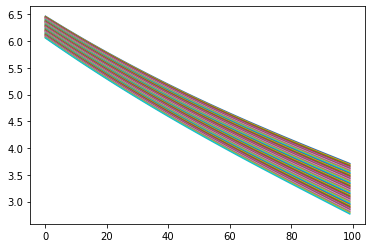

In [44]:
plt.plot(ϕ_i[0])

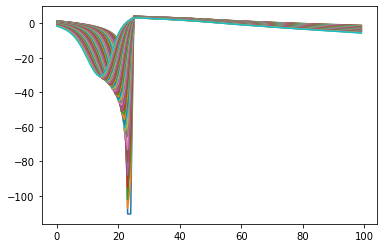

In [45]:
plt.plot(ϕ_i[1])

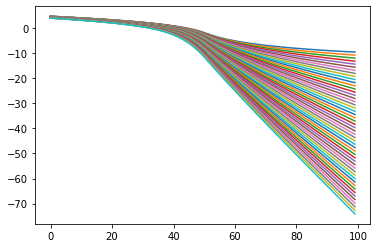

In [46]:
plt.plot(ϕ_i[2])

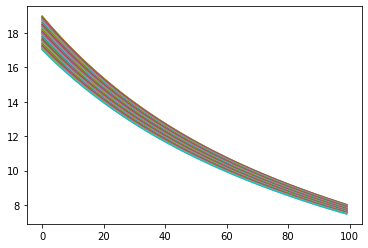

In [48]:
plt.plot(ems_i[0])

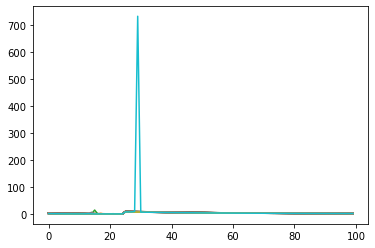

In [51]:
plt.plot(ems_i[1])

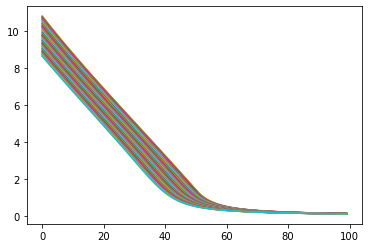

In [50]:
plt.plot(ems_i[2])

In [23]:
def false_transient_robust(y1_grid, y2_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000, print_all=True):
    η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i = model_paras
    dy1 = y1_grid[1] - y1_grid[0]
    dy2 = y2_grid[1] - y2_grid[0]
    (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
    stateSpace = np.hstack([y1_mat.reshape(-1, 1, order='F'), y2_mat.reshape(-1, 1, order='F')])    

    if v0 is None:
        v0 = -η*(y1_mat+y2_mat+(y1_mat+y2_mat)**2)

    d_Λ = γ_1 + γ_2*y1_mat

    πd = np.ones((len(πd_o), len(y1_grid), len(y2_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y1_grid), len(y2_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    bc_y = -ξ_p*np.log(np.sum(πd_o[:, -1, :]*np.exp(-1./ξ_p*ϕ_i[:, -1, :]), axis=0))
    bc = (np.zeros(0), bc_y, np.zeros(0), np.zeros(0))
    impose_bc = (False, True, False, False)

    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()

        v0_dy1 = compute_derivatives(v0, 0, 1, dy1)
        v0_dy2 = compute_derivatives(v0, 1, 1, dy2)        

        e_tilde = -η/(v0_dy2*λ*np.sum(πc_o*θ, axis=0))
        e_tilde[e_tilde<=0] = 1e-15

        log_πc_ratio = -v0_dy2*λ*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        A = np.ones_like(y1_mat) * (-δ)
        B1 = y2_mat
        B2 = λ*(-y2_mat+np.sum(πc_o*θ, axis=0)*e_tilde)
        C1 = np.zeros_like(y1_mat)
        C2 = np.zeros_like(y2_mat)
        D = η*np.log(e_tilde) + (η-1)/δ*d_Λ*y2_mat + ξ_a * c_entropy

        v0 = false_transient_one_iteration_python(A, B1, B2, C1, C2, D, v0, ϵ, dy1, dy2, bc, impose_bc) # CG tol = 1e-10

        rhs_error = A*v0 + B1*v0_dy1 + B2*v0_dy2 + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    res = {'v0': v0,
           'e_tilde': e_tilde}
    return res

In [26]:
nbar = int(y_bar/y1_step) + 1
ϕ_i_short = np.array([temp[:nbar, :] for temp in ϕ_i])
model_paras = (η, δ, θ, γ_1, γ_2, πc_o, πd_o, ξ_a, ξ_p, ϕ_i_short)
model_res = false_transient_robust(y1_grid_short, y2_grid, model_paras,
                                   v0=np.average(ϕ_i_short, weights=πd_o, axis=0),
                                   ϵ=.3, tol=1e-8, max_iter=1000, print_all=True)

Iteration 1: LHS Error: 14.828196889586213; RHS Error 0.0644755397899896
Iteration 2: LHS Error: 2.6240032868787617; RHS Error 3.176429822589759
Iteration 3: LHS Error: 1.832665986059309; RHS Error 2.212108614660604
Iteration 4: LHS Error: 1.2879566908672135; RHS Error 1.5386038648469254
Iteration 5: LHS Error: 1.1187602223409807; RHS Error 1.06527978088345
Iteration 6: LHS Error: 0.9492252693781422; RHS Error 0.8669005083995489
Iteration 7: LHS Error: 0.7871098239163506; RHS Error 0.7323402796673109
Iteration 8: LHS Error: 0.690378669829889; RHS Error 0.6005704896677426
Iteration 9: LHS Error: 0.6175142812736494; RHS Error 0.4852090763884529
Iteration 10: LHS Error: 0.5427630002116753; RHS Error 0.43112872647918593
Iteration 11: LHS Error: 0.4728263228604779; RHS Error 0.37431530115735256
Iteration 12: LHS Error: 0.43494946317525596; RHS Error 0.31835512782420194
Iteration 13: LHS Error: 0.3940784651935222; RHS Error 0.2676638463258713
Iteration 14: LHS Error: 0.3551665076049412; RHS 

Iteration 112: LHS Error: 0.020466188225046388; RHS Error 0.14975846310758192
Iteration 113: LHS Error: 0.020283012162992296; RHS Error 0.1497310279682085
Iteration 114: LHS Error: 0.020095781356996856; RHS Error 0.1497548061226323
Iteration 115: LHS Error: 0.01999458633620499; RHS Error 0.14972774488567847
Iteration 116: LHS Error: 0.019924916503602695; RHS Error 0.14975007657715922
Iteration 117: LHS Error: 0.019851487369477727; RHS Error 0.14972362220953353
Iteration 118: LHS Error: 0.019774192379220512; RHS Error 0.14974401152378888
Iteration 119: LHS Error: 0.019693197840859877; RHS Error 0.14971825614302897
Iteration 120: LHS Error: 0.01960837587906254; RHS Error 0.14973580858396224
Iteration 121: LHS Error: 0.019519920590076456; RHS Error 0.14971129250211074
Iteration 122: LHS Error: 0.01942767442714155; RHS Error 0.1497244367338915
Iteration 123: LHS Error: 0.019331872663261123; RHS Error 0.14970141045695054
Iteration 124: LHS Error: 0.019232307034657836; RHS Error 0.1497060865

Iteration 220: LHS Error: 0.011873368227455217; RHS Error 0.14972348660154966
Iteration 221: LHS Error: 0.011820971300274449; RHS Error 0.1497977727660922
Iteration 222: LHS Error: 0.011767238658260126; RHS Error 0.14962314222160816
Iteration 223: LHS Error: 0.011712063715966597; RHS Error 0.14964898839651408
Iteration 224: LHS Error: 0.01165542312226838; RHS Error 0.14969844932767748
Iteration 225: LHS Error: 0.01159740917875111; RHS Error 0.14963965825522893
Iteration 226: LHS Error: 0.01153802291094556; RHS Error 0.14966431569484895
Iteration 227: LHS Error: 0.01147715295895561; RHS Error 0.14969380151104594
Iteration 228: LHS Error: 0.011414937586569826; RHS Error 0.14969770832997978
Iteration 229: LHS Error: 0.011371467672547375; RHS Error 0.1497114977588193
Iteration 230: LHS Error: 0.011332804187461262; RHS Error 0.14979045370593203
Iteration 231: LHS Error: 0.011292959197621855; RHS Error 0.1497424560685132
Iteration 232: LHS Error: 0.01125175966980289; RHS Error 0.149876968564

Iteration 328: LHS Error: 0.00765011501667523; RHS Error 0.14980178364510963
Iteration 329: LHS Error: 0.00762382673214083; RHS Error 0.1497679595531899
Iteration 330: LHS Error: 0.007596863999498697; RHS Error 0.14978296074142097
Iteration 331: LHS Error: 0.007569243121377708; RHS Error 0.14976594514020714
Iteration 332: LHS Error: 0.007540953859185666; RHS Error 0.14982105643144217
Iteration 333: LHS Error: 0.007511961711054542; RHS Error 0.14992787363758742
Iteration 334: LHS Error: 0.00748233024817561; RHS Error 0.14980192273465182
Iteration 335: LHS Error: 0.007452018875720631; RHS Error 0.14980002638434836
Iteration 336: LHS Error: 0.00742104094404598; RHS Error 0.14976566311807207
Iteration 337: LHS Error: 0.007389393129814496; RHS Error 0.14977668625015317
Iteration 338: LHS Error: 0.0073599965314426665; RHS Error 0.14981387283193917
Iteration 339: LHS Error: 0.007336265992770782; RHS Error 0.14970422649449694
Iteration 340: LHS Error: 0.007311905894923735; RHS Error 0.14970083

Iteration 436: LHS Error: 0.005169870422760958; RHS Error 0.14984619078159872
Iteration 437: LHS Error: 0.005151958160845757; RHS Error 0.14973608990823856
Iteration 438: LHS Error: 0.005133608142625276; RHS Error 0.14975343692381107
Iteration 439: LHS Error: 0.005114987185922774; RHS Error 0.14964439361458676
Iteration 440: LHS Error: 0.005095896504771306; RHS Error 0.14970310959676747
Iteration 441: LHS Error: 0.005076407116394085; RHS Error 0.1498372800443988
Iteration 442: LHS Error: 0.005059211990894319; RHS Error 0.14994904935352724
Iteration 443: LHS Error: 0.005043128563676133; RHS Error 0.14996787288809416
Iteration 444: LHS Error: 0.005026525651616136; RHS Error 0.1497451677329753
Iteration 445: LHS Error: 0.005009613407899553; RHS Error 0.14978427149583795
Iteration 446: LHS Error: 0.004992363673964976; RHS Error 0.14976519603238736
Iteration 447: LHS Error: 0.004974750477860409; RHS Error 0.1497575160399785
Iteration 448: LHS Error: 0.004956769416917991; RHS Error 0.1497446

Iteration 544: LHS Error: 0.0035726172470755086; RHS Error 0.14971327719823135
Iteration 545: LHS Error: 0.0035607229590883804; RHS Error 0.14971476782503185
Iteration 546: LHS Error: 0.0035495300721540466; RHS Error 0.14970541852455632
Iteration 547: LHS Error: 0.0035380699583420494; RHS Error 0.14970559897079636
Iteration 548: LHS Error: 0.0035264009806409056; RHS Error 0.14970998841123018
Iteration 549: LHS Error: 0.0035145805758910837; RHS Error 0.14974141772547178
Iteration 550: LHS Error: 0.003502309829540214; RHS Error 0.14977515265520777
Iteration 551: LHS Error: 0.0034900045983447354; RHS Error 0.14984554214640536
Iteration 552: LHS Error: 0.0034786443097771054; RHS Error 0.14967581887253328
Iteration 553: LHS Error: 0.003467603126209677; RHS Error 0.14969108861076164
Iteration 554: LHS Error: 0.0034564223200087936; RHS Error 0.14969136053587395
Iteration 555: LHS Error: 0.0034449806288527896; RHS Error 0.1496961243645755
Iteration 556: LHS Error: 0.0034333319696363183; RHS Er

Iteration 649: LHS Error: 0.0023315184657561145; RHS Error 0.1496695319625866
Iteration 650: LHS Error: 0.0023147001481375424; RHS Error 0.14967399301354256
Iteration 651: LHS Error: 0.002297735083862662; RHS Error 0.14968939232487188
Iteration 652: LHS Error: 0.0022806765793544534; RHS Error 0.1496936074865775
Iteration 653: LHS Error: 0.0022635103960144676; RHS Error 0.14970251334025542
Iteration 654: LHS Error: 0.0022461686986681904; RHS Error 0.14976025539132062
Iteration 655: LHS Error: 0.0022287578394427263; RHS Error 0.14983721754697615
Iteration 656: LHS Error: 0.0022112221114974537; RHS Error 0.14970182302538998
Iteration 657: LHS Error: 0.002193616297653615; RHS Error 0.14973216335135556
Iteration 658: LHS Error: 0.0021758771495120994; RHS Error 0.14961829115461317
Iteration 659: LHS Error: 0.0021580142449491766; RHS Error 0.1496494909037441
Iteration 660: LHS Error: 0.002140121955690096; RHS Error 0.14965310470568735
Iteration 661: LHS Error: 0.0021221149225662357; RHS Error

Iteration 754: LHS Error: 0.0005757054317090393; RHS Error 0.14973835618154024
Iteration 755: LHS Error: 0.0006174257920399384; RHS Error 0.14973895122216035
Iteration 756: LHS Error: 0.0005579153431186276; RHS Error 0.14975749135031863
Iteration 757: LHS Error: 0.00068886903829668; RHS Error 0.14975675169959551
Iteration 758: LHS Error: 0.0016650154007979978; RHS Error 0.14983145257674366
Iteration 759: LHS Error: 0.0010980811926971277; RHS Error 0.14969343235384497
Iteration 760: LHS Error: 0.0005121464296416652; RHS Error 0.1497168016824595
Iteration 761: LHS Error: 0.0006196446421894801; RHS Error 0.1497594135527735
Iteration 762: LHS Error: 0.0004921966054786491; RHS Error 0.14972895053986307
Iteration 763: LHS Error: 0.00048242537239081196; RHS Error 0.14974362242581396
Iteration 764: LHS Error: 0.0005780863777848921; RHS Error 0.14972260349458602
Iteration 765: LHS Error: 0.0005448818729962095; RHS Error 0.14974194011084652
Iteration 766: LHS Error: 0.001038077369911091; RHS Err

Iteration 859: LHS Error: 0.00016025970638840667; RHS Error 0.1497172519047083
Iteration 860: LHS Error: 0.0010238170756767437; RHS Error 0.1497205911565806
Iteration 861: LHS Error: 0.00028887701137995475; RHS Error 0.14976670564892608
Iteration 862: LHS Error: 0.0005559714127641632; RHS Error 0.14980278639502603
Iteration 863: LHS Error: 0.0009471463725363449; RHS Error 0.14977241329983673
Iteration 864: LHS Error: 0.002012092530455275; RHS Error 0.14982819005488984
Iteration 865: LHS Error: 0.0008433204858556328; RHS Error 0.14964162234649808
Iteration 866: LHS Error: 0.000525211852435703; RHS Error 0.14965861409211176
Iteration 867: LHS Error: 0.0011417864373486353; RHS Error 0.14967138404572988
Iteration 868: LHS Error: 0.0006471833353301667; RHS Error 0.149707303924417
Iteration 869: LHS Error: 0.00031477275624247625; RHS Error 0.1497005257479051
Iteration 870: LHS Error: 0.00020430258583263122; RHS Error 0.14969541495135583
Iteration 871: LHS Error: 0.0006473400323736556; RHS Er

Iteration 964: LHS Error: 0.00021058402408661675; RHS Error 0.1497525922667322
Iteration 965: LHS Error: 0.0008476577526739248; RHS Error 0.14974385685671762
Iteration 966: LHS Error: 0.0006861510578544857; RHS Error 0.14977078385299852
Iteration 967: LHS Error: 0.00031599283679906165; RHS Error 0.14973089248614435
Iteration 968: LHS Error: 0.0005667313801493989; RHS Error 0.14971819843745798
Iteration 969: LHS Error: 0.0003301646628709835; RHS Error 0.14972904863623043
Iteration 970: LHS Error: 0.00018093304006816524; RHS Error 0.14971922717053437
Iteration 971: LHS Error: 0.0006112028836543123; RHS Error 0.14971674090217146
Iteration 972: LHS Error: 0.00020632347360457123; RHS Error 0.14974250061469604
Iteration 973: LHS Error: 0.0007592356226338026; RHS Error 0.14975223276454921
Iteration 974: LHS Error: 0.00034893137127234297; RHS Error 0.14981851308617342
Iteration 975: LHS Error: 0.0008542294326163713; RHS Error 0.14981637465668546
Iteration 976: LHS Error: 0.0004911139331727673;

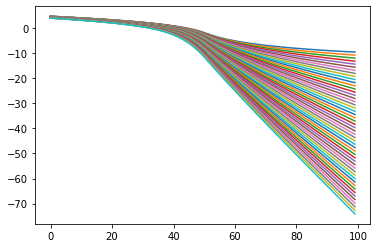

In [35]:
plt.plot(model_res['v0'])

In [28]:
np.save('emission_two_state', model_res['e_tilde'])

In [47]:
ems_i_short = np.array([temp[:nbar, :] for temp in ems_i])
np.save('emission_two_state_low', ems_i[0])
np.save('emission_two_state_high', ems_i[1])
np.save('emission_two_state_extreme', ems_i[2])